In [1]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.ticker as mtick
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('../data/aug_train.csv')
df_test = pd.read_csv('../data/aug_test.csv')

In [5]:
df.drop(['enrollee_id'], axis=1, inplace=True)

In [6]:
df.describe().T

count       mean        std    min    25%     50%  \
city_development_index  19158.0   0.828848   0.123362  0.448   0.74   0.903   
training_hours          19158.0  65.366896  60.058462  1.000  23.00  47.000   
target                  19158.0   0.249348   0.432647  0.000   0.00   0.000   

                          75%      max  
city_development_index   0.92    0.949  
training_hours          88.00  336.000  
target                   0.00    1.000

In [7]:
def fill_column_na(feature, value, df = df):
    df[feature].fillna(value, inplace=True)
    return df[feature].value_counts()

In [8]:
df.isna().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [9]:
fill_column_na('gender', 'Undisclosed')
fill_column_na('enrolled_university', 'Undisclosed')
fill_column_na('education_level', 'Undisclosed')
fill_column_na('major_discipline', 'Undisclosed')
fill_column_na('experience', '0')
fill_column_na('company_size', 'Undisclosed')
fill_column_na('company_type', 'Other')
fill_column_na('last_new_job', 'never')
df.isna().sum()


city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [10]:
df['company_size'] = df['company_size'].apply(lambda x: '10-49' if x == '10/49' else x)

In [11]:
df['experience'] = df['experience'].apply(lambda x: '0' if x == '<1' else x)
df['experience'] = df['experience'].apply(lambda x: '20' if x == '>20' else x)

In [12]:
background_color = "#fbfbfb"
color_palette=["gray","#0e4f66"]

In [13]:
def class_balance(df):
    x = df.groupby(['target'])['target'].count()
    y = len(df)
    r = ((x/y)).round(2)
    ratio = pd.DataFrame(r).T

    fig, ax = plt.subplots(1, 1, figsize=(6, 2), dpi=300)

    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    ax.barh(ratio.index, ratio[1.0], color='#0e4f66', label='Job-Seeker')
    ax.barh(ratio.index, ratio[0.0], color='gray', label='Non Job-Seeker', left=ratio[1.0])

    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().set_visible(False)

    for s in ['top', 'left', 'right', 'bottom']:
        ax.spines[s].set_visible(False)

    for i in ratio.index:
        ax.annotate(f"{int(ratio[1][i] * 100)}%", xy=(ratio[1][i]/2, i), va='center', ha='center', fontsize = 28, fontweight='bold', color='white')
        ax.annotate("Seeking", xy=(ratio[1.0][i] / 2, -0.25), va = 'center', ha='center', fontsize = 12, fontweight='light', color='white')

    for i in ratio.index:
        ax.annotate(f"{int(ratio[0][i]*100)}%", xy=(ratio[1][i]+ratio[0][i]/2, i), va='center', ha='center', fontsize=28, fontweight='bold', color='white')
        ax.annotate("Not Seeking", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25), va = 'center', ha='center', fontsize=12, fontweight='light', color='white')

    fig.text(0.175, 0.9, 'How many are looking for a new role?', fontsize=14, fontweight='bold')

    plt.savefig('../img/imbalance.png', format='png')

    return plt.show()

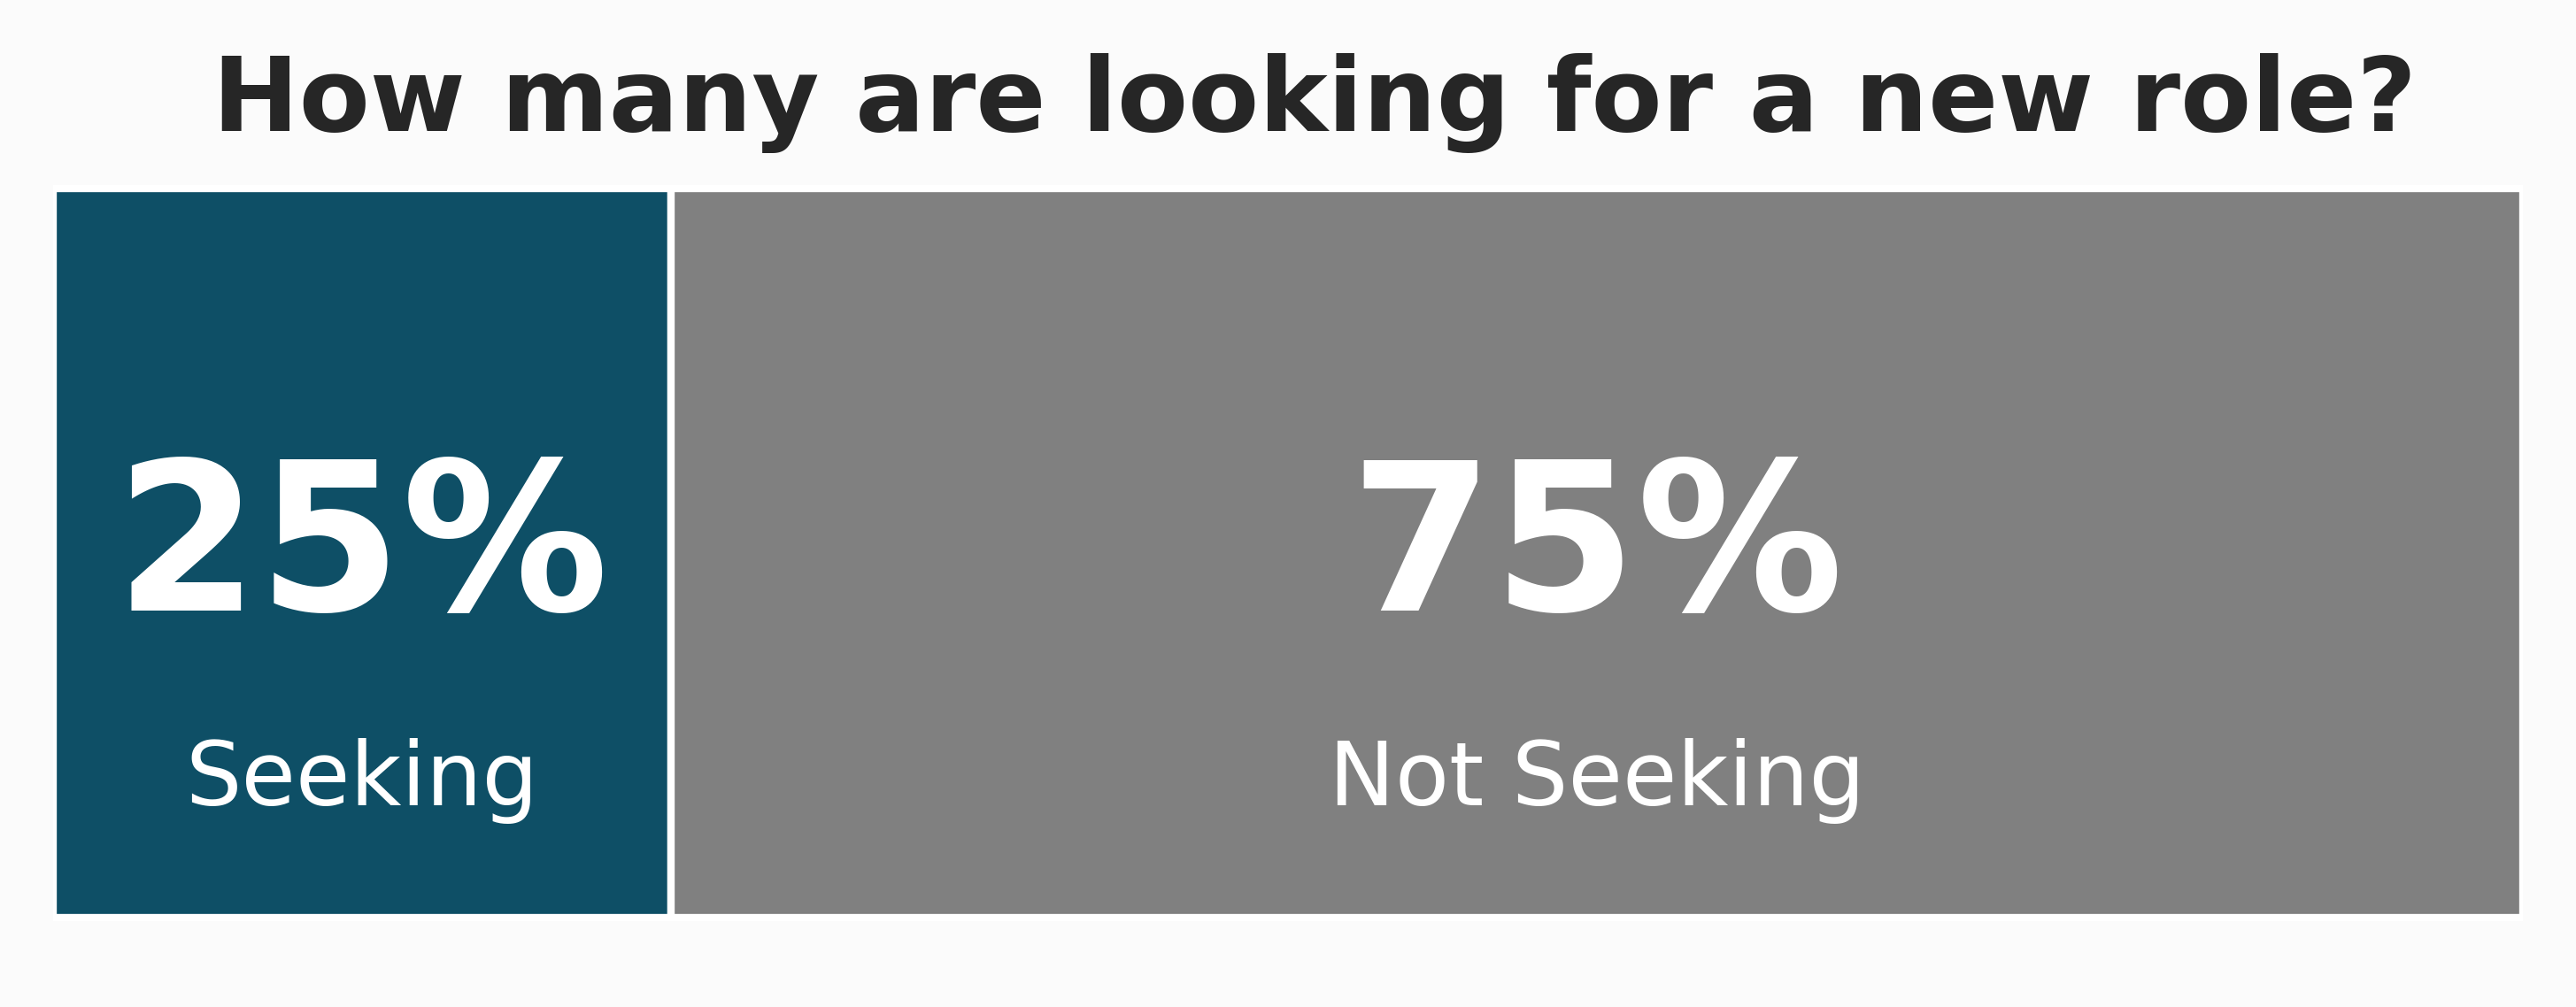

In [14]:
class_balance(df)

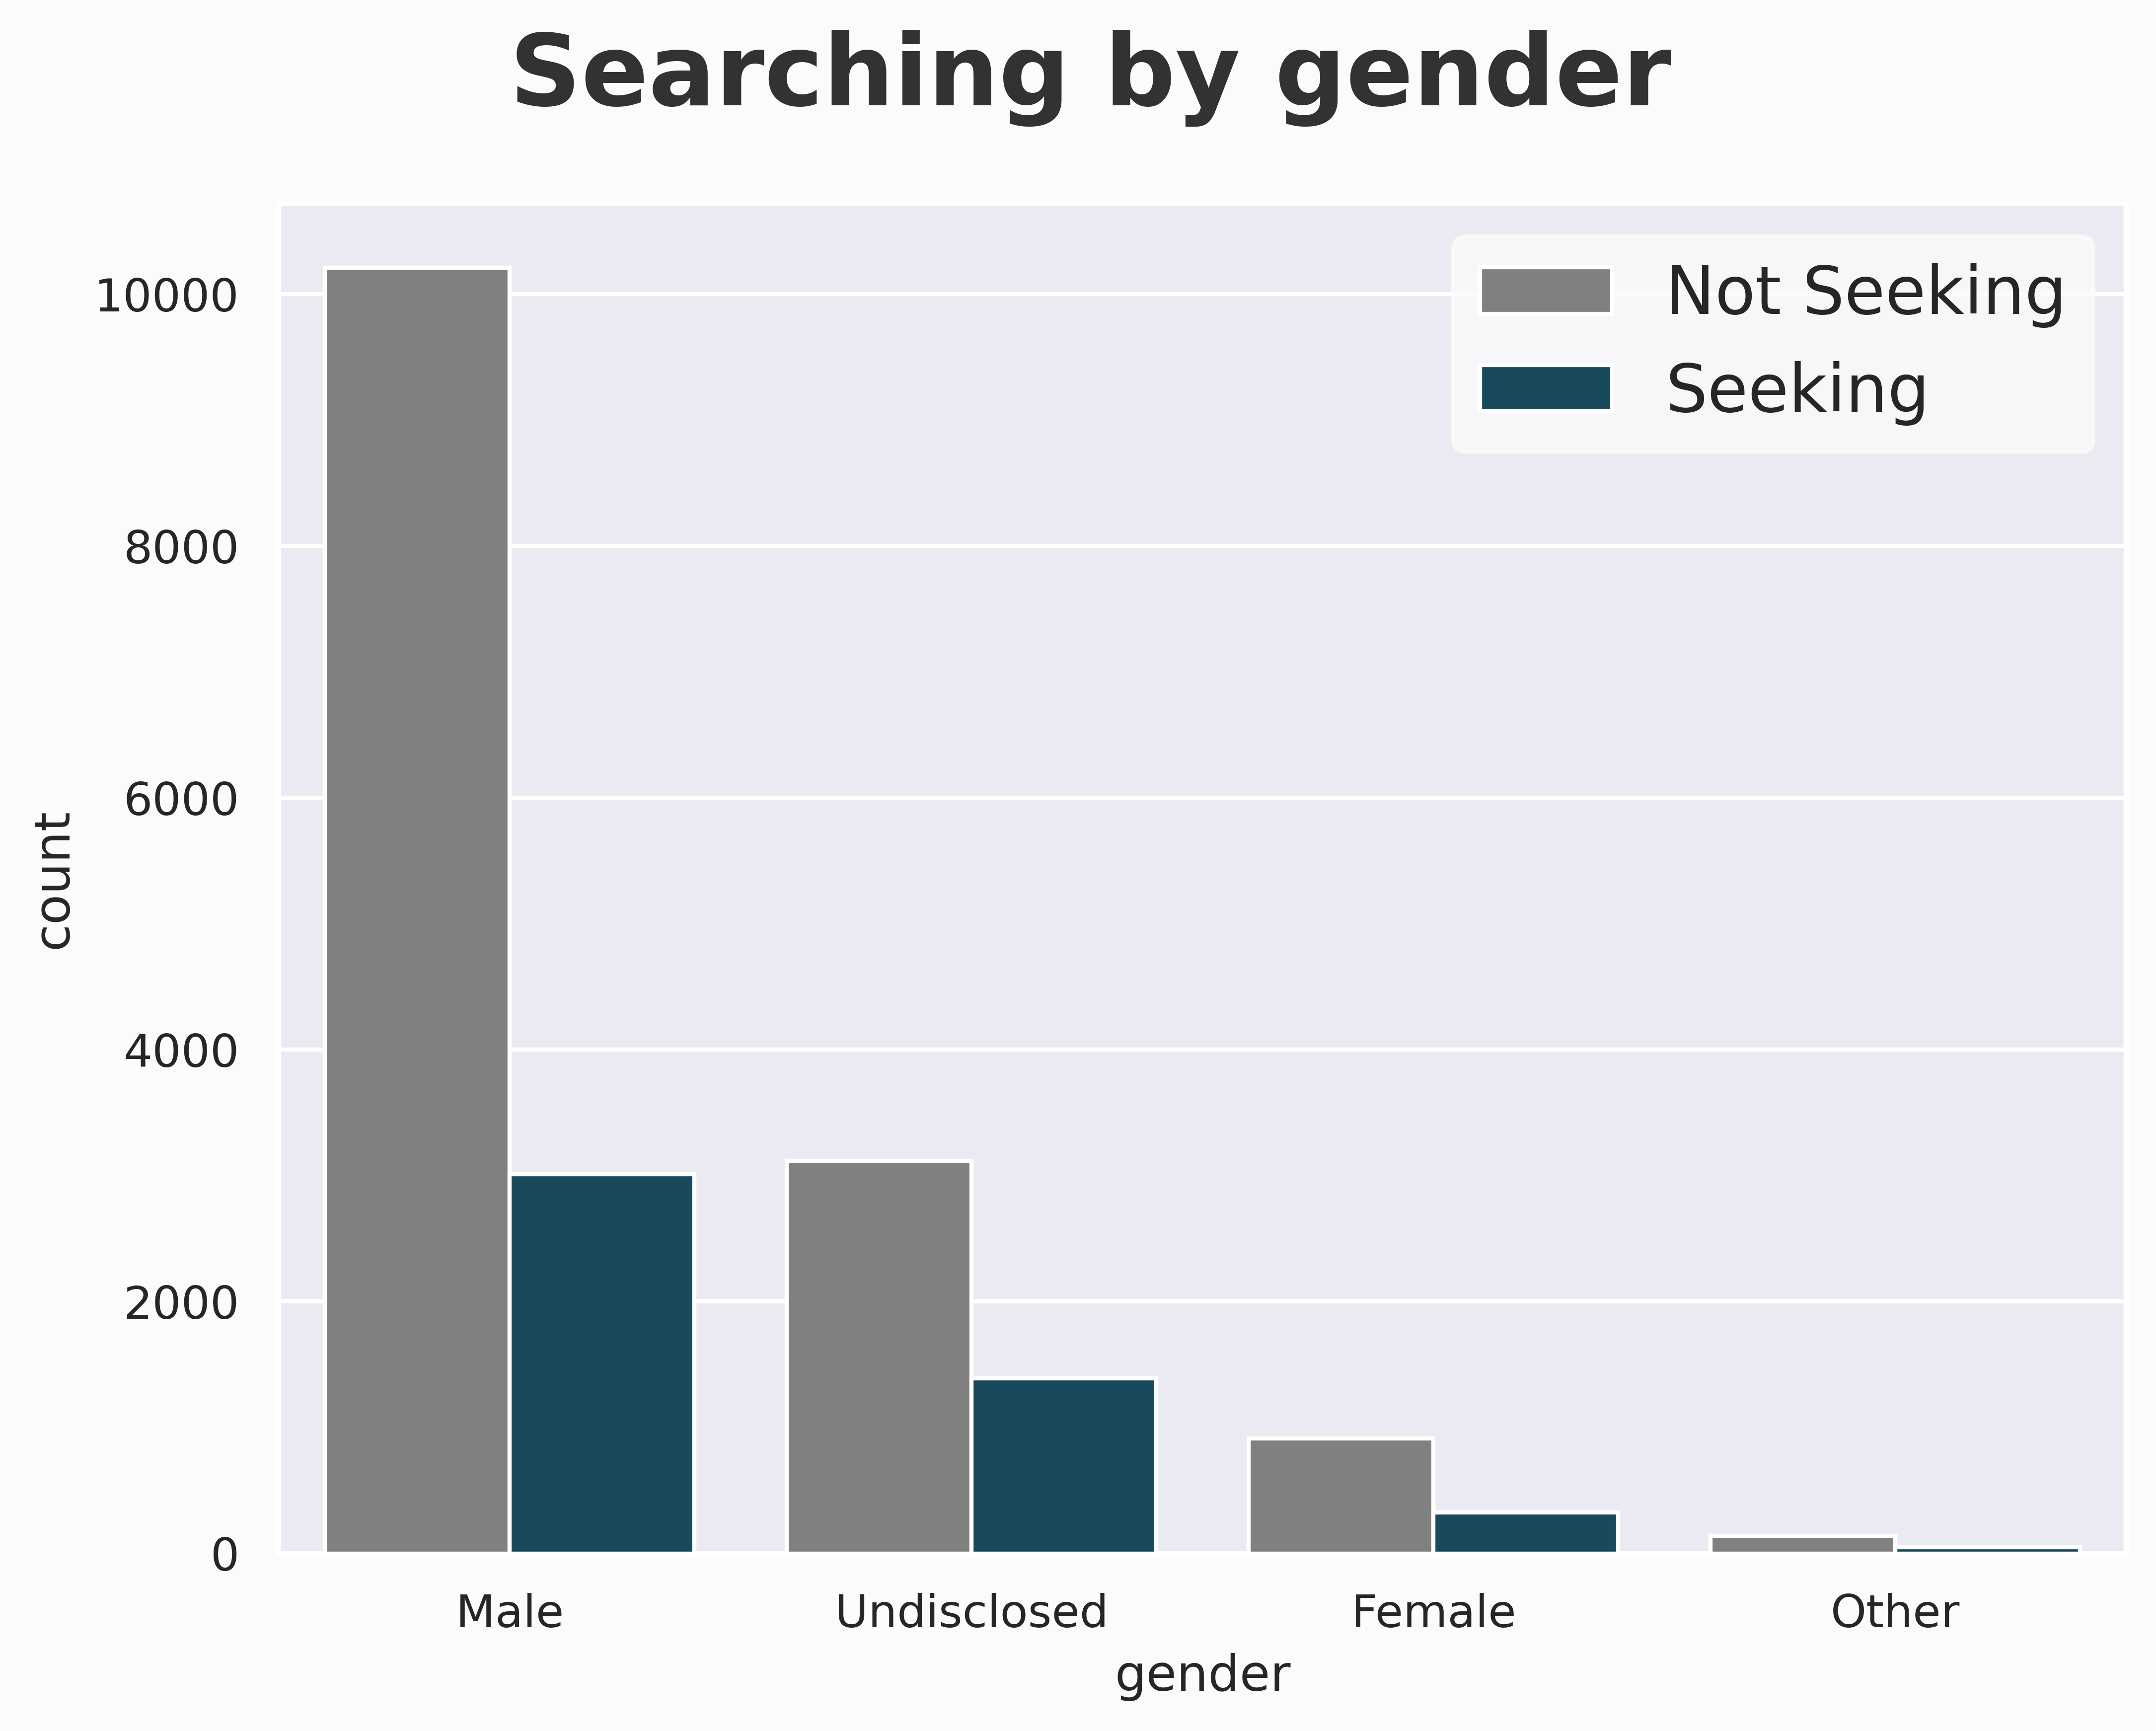

In [15]:
def seekers_by_gender(df):    
    fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=300)
    fig.patch.set_facecolor(background_color)

    ax.text(0, 11500, 'Searching by gender', fontsize=24, fontweight='bold', color="#323232")

    sns.countplot(x="gender", hue="target", data=df, palette=color_palette, ax=ax, zorder=3)
    
    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(legend_labels, ["Not Seeking", "Seeking"], facecolor=background_color, edgecolor=background_color, fontsize=16)

    plt.savefig('../img/by_gender.png', format='png')

    return plt.show()

seekers_by_gender(df)

In [16]:
def last_job_duration(df):
    job_order = ['never', '1', '2', '3', '4', '>4']

    fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=300)
    fig.patch.set_facecolor(background_color)

    ###
    df['count'] = 1

    job_hunt_only = df[df['target'] == 1]
    no_job_hunt_only = df[df['target'] == 0]

    job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack()

    notseek_job_change = no_job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T
    seek_job_change = job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T

    notseek_job_change.columns = ['count']
    seek_job_change.columns = ['count']

    notseek_job_change["percentage"] = notseek_job_change["count"].apply(lambda x: x/sum(notseek_job_change["count"])) *100
    seek_job_change["percentage"] = seek_job_change["count"].apply(lambda x: x/sum(seek_job_change["count"])) *100

    ###
    ax.text(6.2, 5.8, 'Last job duration (years)', fontsize=20, fontweight='bold', color='#323232')

    ax.barh(notseek_job_change.index, notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
    ax.barh(seek_job_change.index, seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
    ax.xaxis.set_major_locator(mtick.MultipleLocator(10))

    return plt.show()

In [17]:
df['experience'].value_counts()

20    3434
5     1430
4     1403
3     1354
6     1216
2     1127
7     1028
10     985
9      980
8      802
15     686
11     664
0      587
14     586
1      549
16     508
12     494
13     399
17     342
19     304
18     280
Name: experience, dtype: int64

In [18]:
def company_heatmap(df):
    genders = ['Male','Female','Other','Undisclosed']
    size_order = ['Undisclosed', '<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
    duration_order = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']

    pv_gen_size = pd.pivot_table(df, values='count', index=['gender'], columns=['company_size'], aggfunc=np.sum).loc[genders, size_order]
    ct_gen_size = pd.crosstab(df['company_size'], df['experience'], normalize='index').loc[size_order, duration_order]

    fig = plt.figure(figsize=(15,10), dpi=300) 
    fig.patch.set_facecolor(background_color)

    gs = fig.add_gridspec(2, 1)
    gs.update(wspace=0, hspace=-0.09)

    ax = fig.add_subplot(gs[:,:])

    colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
    colormap = clrs.LinearSegmentedColormap.from_list("", colors)

    sns.heatmap(ax=ax, data=ct_gen_size, linewidths=.1, vmax=0.09, square=True, cbar=False, cmap=colormap, linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})
    
    ax.set_facecolor(background_color) 
    ax.set_xlabel("Employee Experience [years]", fontsize=14, loc='center')
    ax.set_ylabel("")

    for s in ["top","right","left"]:
        ax.spines[s].set_visible(False)

        
    ax.text(4, -.3, 'Distribution: Company size vs employee experience', 
            fontsize=20, 
            fontweight='bold'
            )

    ax.tick_params(axis=u'both', which=u'both', length=0)

    plt.savefig('../img/distribution_heatmap.png', format='png')

    return plt.show();

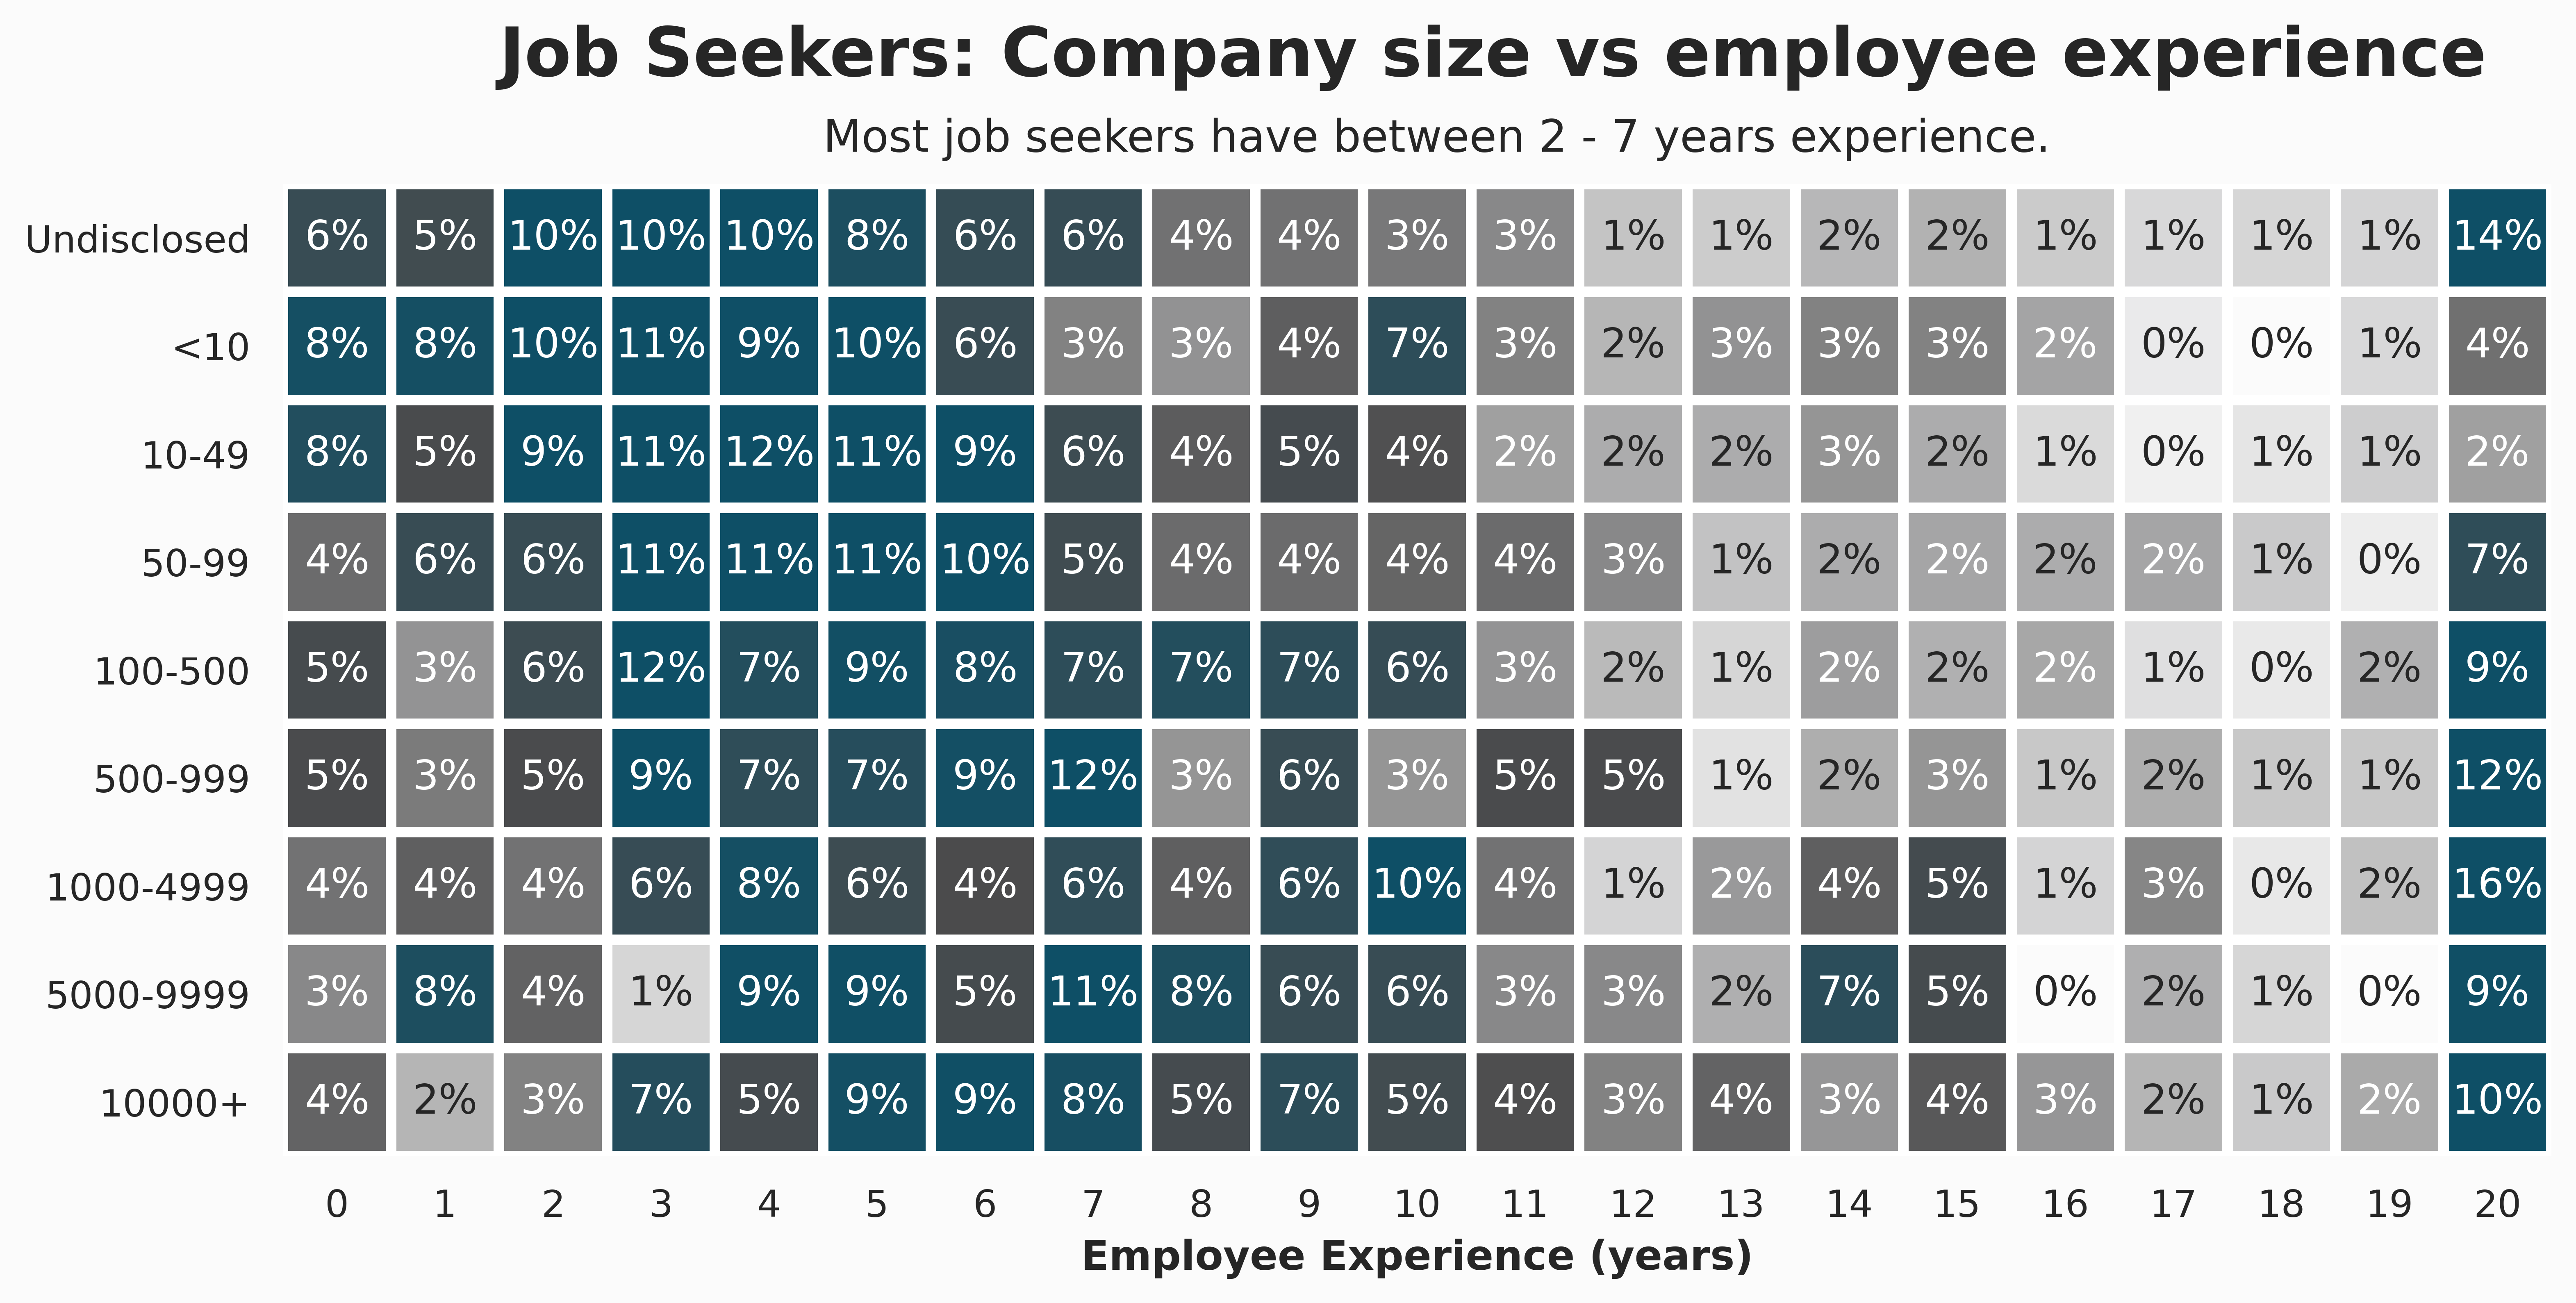

In [19]:
def job_seekers_heatmap(df):
    genders = ['Male','Female','Other']
    size_order = ['Undisclosed', '<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
    duration_order = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']

    seeking = df[df['target']==1]
    job_seek = pd.crosstab(seeking['company_size'], seeking['experience'], normalize='index').loc[size_order, duration_order]

    fig = plt.figure(figsize=(15, 10), dpi=300)
    fig.patch.set_facecolor(background_color)
    gs = fig.add_gridspec(2, 3)
    gs.update(wspace=0, hspace=-0.09)    
    ax = fig.add_subplot(gs[0,:])

    colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
    colormap = clrs.LinearSegmentedColormap.from_list("", colors)

    sns.heatmap(ax=ax, data=job_seek, linewidths=.1, vmin=0, vmax=0.09, square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":12})

    ax.set_facecolor(background_color) 
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlabel("Employee Experience (years)", fontsize=12, fontweight='bold', loc='center')

    for s in ["top","right","left"]:
        ax.spines[s].set_visible(False)
        
    ax.text(2, -1, 'Job Seekers: Company size vs employee experience', fontsize=20, fontweight='bold')
    ax.text(5, -0.3, 'Most job seekers have between 2 - 7 years experience.', fontsize=13, fontweight='light')


    plt.savefig('../img/job_seekers_heatmap.png', format='png')

    return plt.show()

job_seekers_heatmap(df)

In [20]:
def identify_categorical(df):
    categorical = (df.dtypes == "object")
    return list(categorical[categorical].index)

In [21]:
# def create_encoded_df(df):
#     categorical_list = identify_categorical(df)

#     for cat in range(len(categorical_list)):
#         category = categorical_list[cat]
#         df[category] = pd.Categorical(df[category])
#         dummies = pd.get_dummies(df[category], prefix = category)
#         df.drop([category], axis=1, inplace=True)
#         df = pd.concat([df, dummies], axis=1)

#     return df

## Encoded df

In [22]:
def create_encoded_df(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df

In [23]:
X = df.drop(['target'], axis = 1)
y = df['target']

num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

X = create_encoded_df(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [24]:
# get_dummies

# cat_X = df[identify_categorical(df)]
# ohe = OneHotEncoder(sparse=False, drop='first')
# ohe.fit(cat_X)
# cats = ohe.transform(X)

In [25]:
# encoded_df = create_encoded_df(df)
# encoded_df

In [26]:
# Split the data 60 train / 20 val / 20 test
def split_train_val_test(df, target = 'target', random_state=42):
    X = df.drop([target], axis =1)
    y = df[target]

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=random_state)

    # print(f'Total # of whole dataset: {len(X)}')
    # print(f'Total # of train dataset: {len(X_train)}')
    # print(f'Total # of validation dataset: {len(X_val)}')
    # print(f'Total # of test dataset: {len(X_test)}')

    return X_train, y_train, X_val, y_val, X_test, y_test

In [27]:
def create_pipeline(name, model):
    return Pipeline(steps=[("scaler", StandardScaler()), (name, model)])

In [28]:
train_scores = []
val_scores = []
test_scores = []
f1_scores = []
acc_scores = []
prec_scores = []
recall_scores = []
matrices = []

def describe_pipeline(model_name):
    pipeline_dict[model_name].fit(X_train, y_train)

    print(model_name)
    print("Train Score : %f" % (pipeline_dict[model_name].score(X_train, y_train) * 100))
    print("Val Score   : %f" % (pipeline_dict[model_name].score(X_val, y_val) * 100))
    print("Test Score  : %f" % (pipeline_dict[model_name].score(X_test, y_test) * 100))

    train_scores.append(pipeline_dict[model_name].score(X_train, y_train) * 100)    
    val_scores.append(pipeline_dict[model_name].score(X_val, y_val) * 100)    
    test_scores.append(pipeline_dict[model_name].score(X_test, y_test) * 100)

    print(" ")
    
    y_predictions = pipeline_dict[model_name].predict(X_test)

    conf_matrix = confusion_matrix(y_predictions, y_test)
    matrices.append(conf_matrix)

    print(f'Confussion Matrix: \n{conf_matrix}\n')
    
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]

    total = tn + fp + tp + fn
    real_positive = tp + fn
    real_negative = tn + fp

    precision = tp / (tp + fp) # Positive Predictive Value
    recall    = tp / (tp + fn) # True Positive Rate
    accuracy  = (tp + tn) / total # Accuracy Rate
    f1score  = 2 * precision * recall / (precision + recall)

    prec_scores.append(precision)
    recall_scores.append(recall)
    acc_scores.append(accuracy)
    f1_scores.append(f1score)

    error_rate = (fp + fn) / total # Missclassification Rate
    
    # print('Evaluation Metrics:')
    # print(f'Precision : {precision:.3f}')
    # print(f'Recall    : {recall:.3f}')
    # print(f'Accuracy  : {accuracy:.3f}')
    # print(f'F1 score  : {f1score:.3f}')

    print("") 
    print(f'Classification Report: \n{classification_report(y_predictions, y_test)}\n')
    print("")

In [29]:
pipeline_dict = {
    'LogisticRegression': create_pipeline('pipeline_LogisticRegression', LogisticRegression()),
    'DecisionTreeClassifier': create_pipeline('pipeline_DecisionTree', DecisionTreeClassifier()),
    'RandomForestClassifier': create_pipeline('pipeline_RandomForest', RandomForestClassifier()),
    'KNeighborsClassifier': create_pipeline('pipeline_KNN', KNeighborsClassifier())
    }

model_names = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier']

In [30]:
# train_scores = []
# validation_scores = []
# test_scores = []

In [31]:
describe_pipeline('LogisticRegression')

LogisticRegression
Train Score : 76.866191
Val Score   : 76.565762
Test Score  : 77.557411
 
Confussion Matrix: 
[[2685  665]
 [ 195  287]]


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      3350
         1.0       0.30      0.60      0.40       482

    accuracy                           0.78      3832
   macro avg       0.62      0.70      0.63      3832
weighted avg       0.85      0.78      0.80      3832





In [32]:
describe_pipeline('DecisionTreeClassifier')

DecisionTreeClassifier
Train Score : 99.904298
Val Score   : 72.390397
Test Score  : 70.433194
 
Confussion Matrix: 
[[2284  537]
 [ 596  415]]


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      2821
         1.0       0.44      0.41      0.42      1011

    accuracy                           0.70      3832
   macro avg       0.61      0.61      0.61      3832
weighted avg       0.70      0.70      0.70      3832





In [33]:
describe_pipeline('RandomForestClassifier')

RandomForestClassifier
Train Score : 99.904298
Val Score   : 77.896660
Test Score  : 77.766180
 
Confussion Matrix: 
[[2535  507]
 [ 345  445]]


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86      3042
         1.0       0.47      0.56      0.51       790

    accuracy                           0.78      3832
   macro avg       0.67      0.70      0.68      3832
weighted avg       0.80      0.78      0.78      3832





In [34]:
describe_pipeline('KNeighborsClassifier')

KNeighborsClassifier
Train Score : 83.286932
Val Score   : 75.600209
Test Score  : 75.939457
 
Confussion Matrix: 
[[2496  538]
 [ 384  414]]


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      3034
         1.0       0.43      0.52      0.47       798

    accuracy                           0.76      3832
   macro avg       0.65      0.67      0.66      3832
weighted avg       0.78      0.76      0.77      3832





In [35]:
models_table = pd.DataFrame({
    'Model': model_names,
    'Train': train_scores,
    'Validation': val_scores,
    'Test': test_scores,
    'Precision': prec_scores,
    'Recall': recall_scores,
    'F1': f1_scores
    }).set_index('Model')


models_table

Train  Validation       Test  Precision    Recall  \
Model                                                                           
LogisticRegression      76.866191   76.565762  77.557411   0.301471  0.595436   
DecisionTreeClassifier  99.904298   72.390397  70.433194   0.435924  0.410485   
RandomForestClassifier  99.904298   77.896660  77.766180   0.467437  0.563291   
KNeighborsClassifier    83.286932   75.600209  75.939457   0.434874  0.518797   

                              F1  
Model                             
LogisticRegression      0.400279  
DecisionTreeClassifier  0.422822  
RandomForestClassifier  0.510907  
KNeighborsClassifier    0.473143

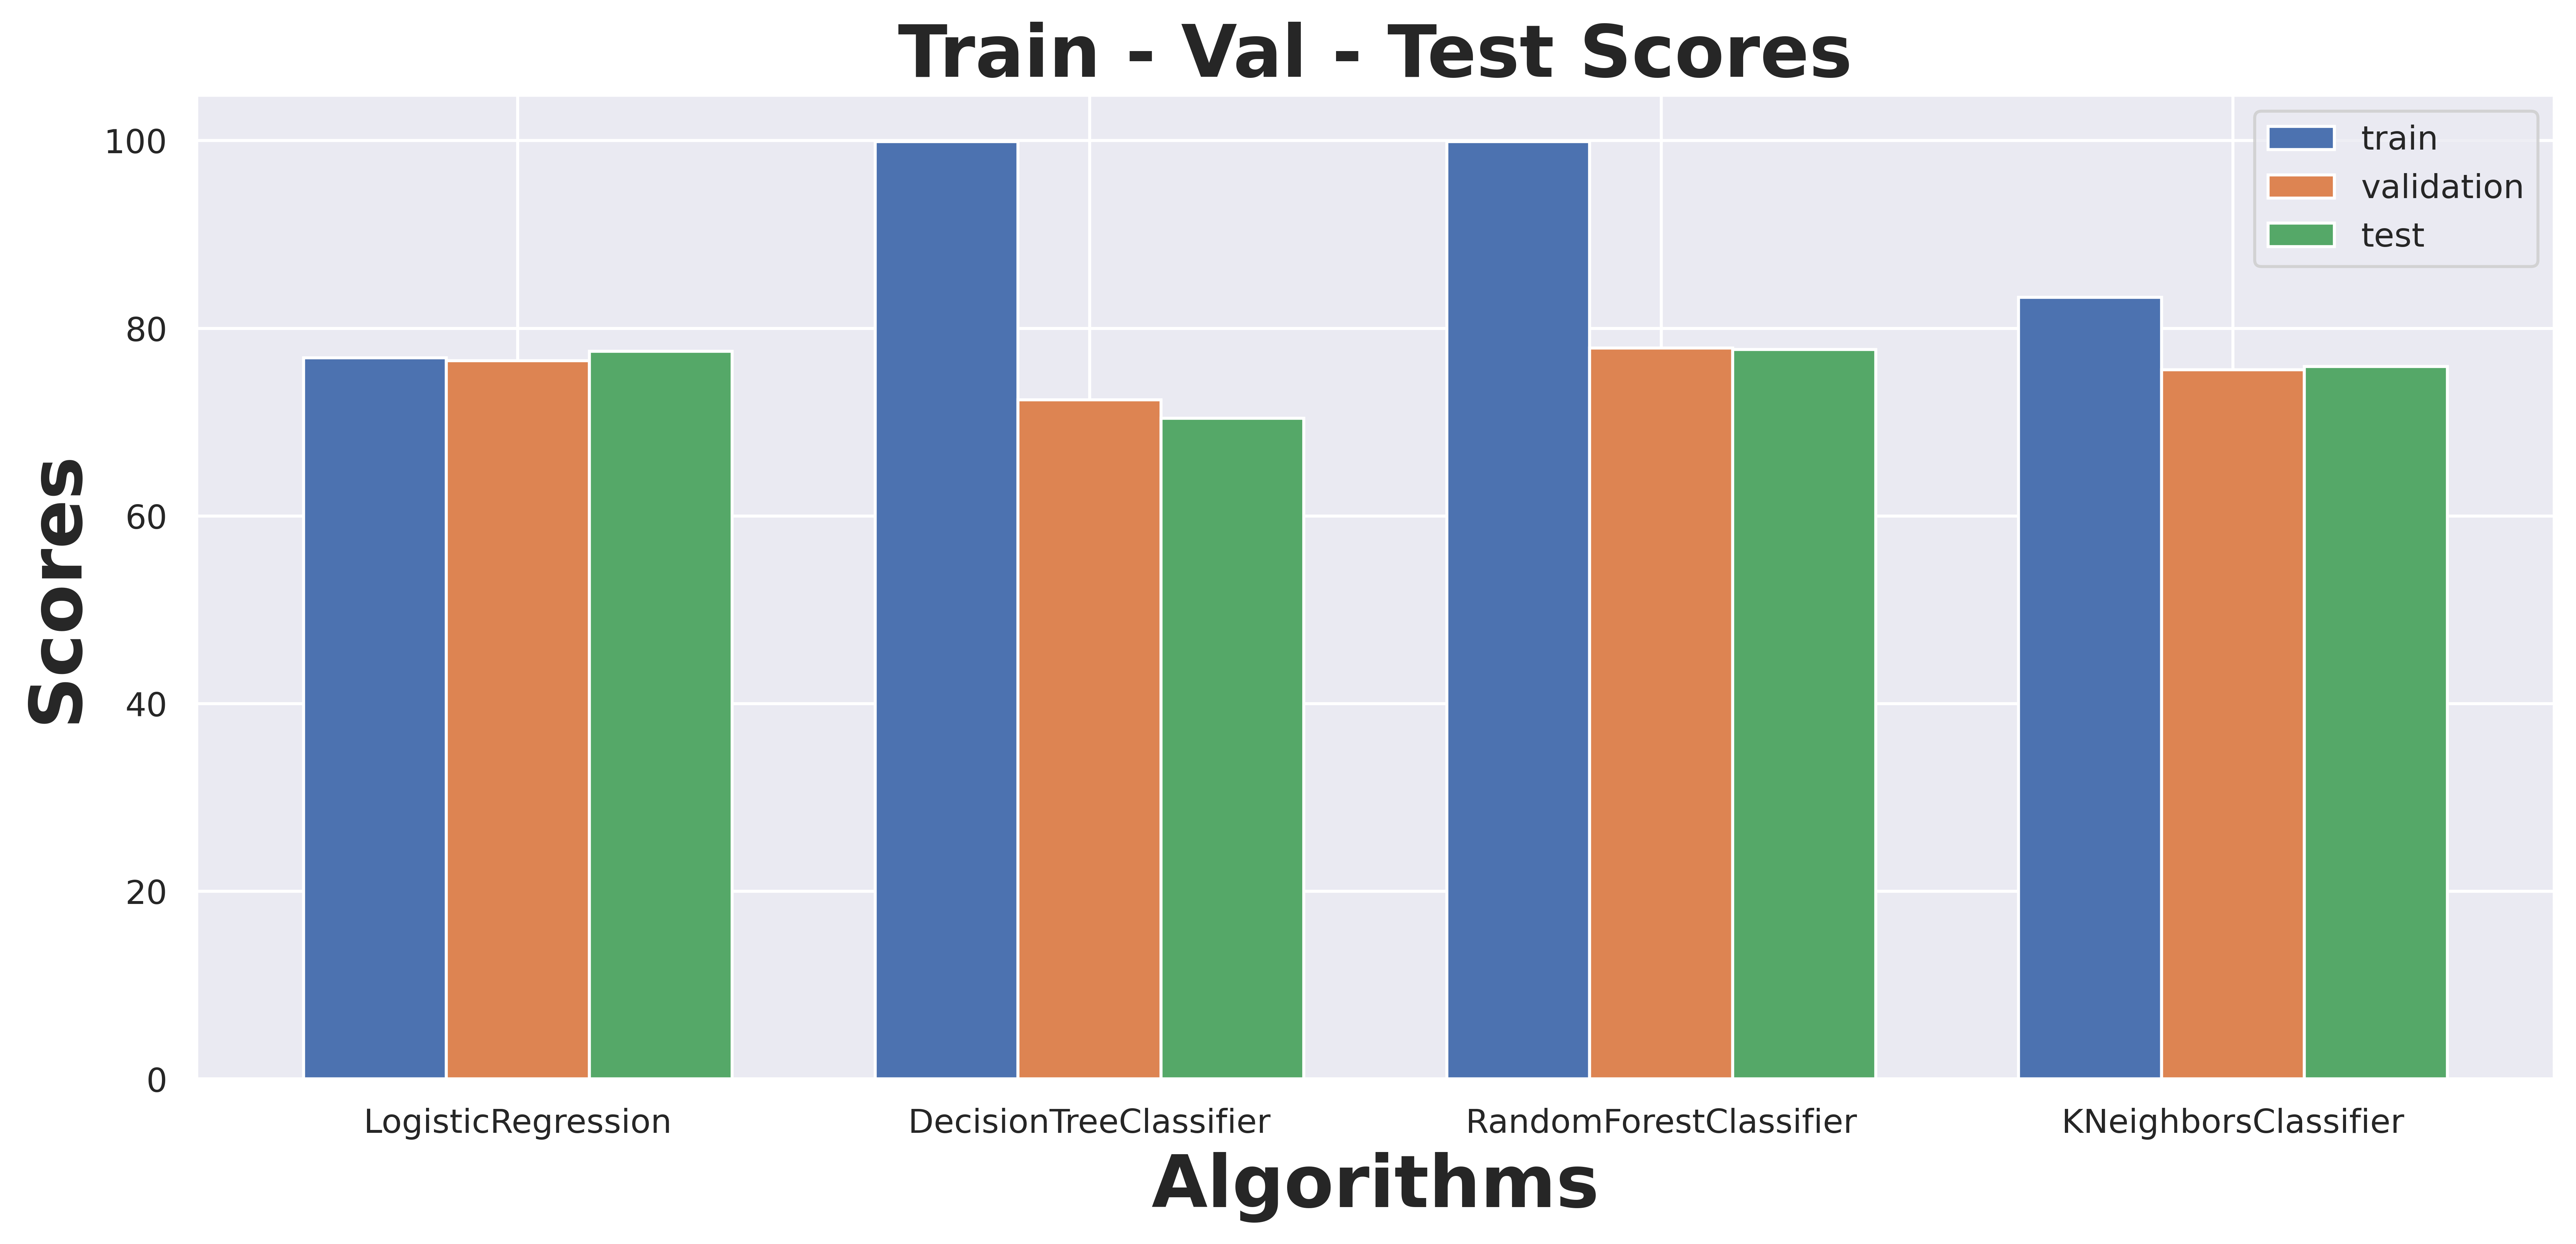

In [36]:
plt.figure(figsize=(14, 6), dpi=300)
sns.set_style('darkgrid')
plt.title('Train - Val - Test Scores', fontweight='bold', size = 24)

barWidth = 0.25

bar1 = train_scores
bar2 = val_scores
bar3 = test_scores

b1 = np.arange(len(bar1))
b2 = [x + barWidth for x in b1]
b3 = [x + barWidth for x in b2]

plt.bar(b1, bar1, width=barWidth, label='train')
plt.bar(b2, bar2, width=barWidth, label='validation')
plt.bar(b3, bar3, width=barWidth, label='test')

plt.xlabel('Algorithms', fontweight='bold', size = 24)
plt.ylabel('Scores', fontweight='bold', size = 24)
plt.xticks([r + barWidth for r in range(len(bar1))], model_names, rotation = 0)

plt.legend(bbox_to_anchor=(.995, .99), borderaxespad=0)

plt.savefig('../img/pipelines.png')

plt.legend()
plt.show()


## Cross Validation

In [37]:
cv_results = []

for model in pipeline_dict:
    cv_score = cross_val_score(pipeline_dict[model], X_train, y_train, scoring = "accuracy", cv = 50)
    cv_results.append(cv_score.mean() * 100)
    print("%s: %f" % (model, cv_score.mean() * 100))

LogisticRegression: 76.866224
DecisionTreeClassifier: 71.619138
RandomForestClassifier: 79.005886
KNeighborsClassifier: 76.525840


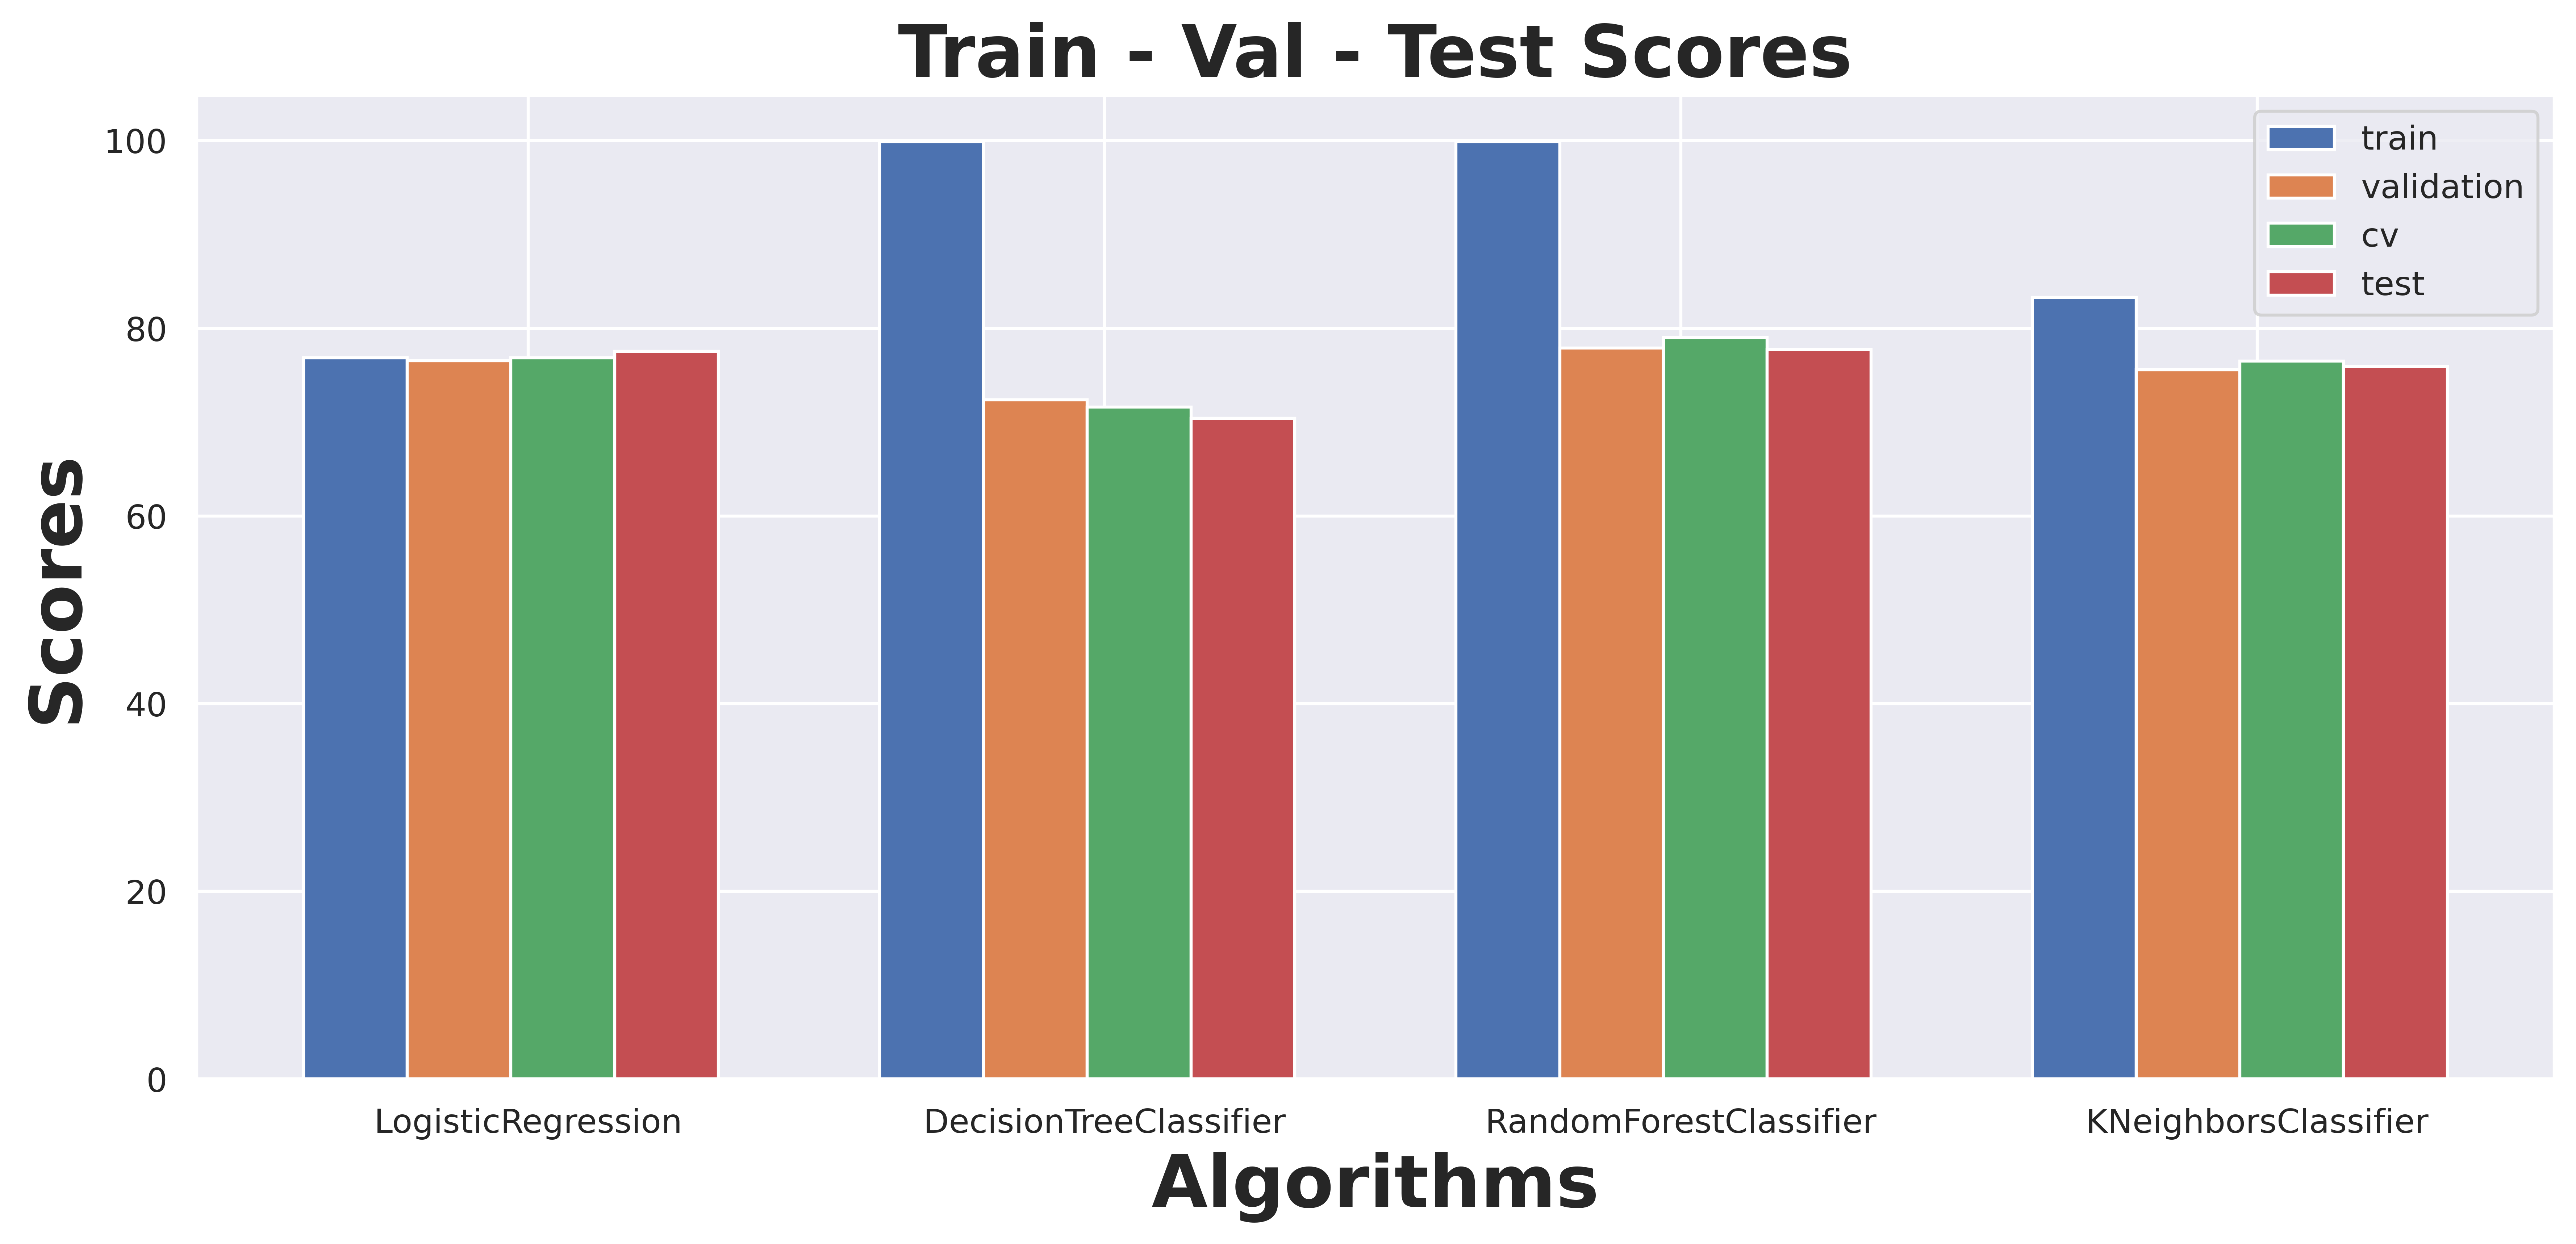

In [38]:
plt.figure(figsize=(14, 6), dpi=300)
sns.set_style('darkgrid')
plt.title('Train - Val - Test Scores', fontweight='bold', size = 24)

barWidth = 0.18

bar1 = train_scores
bar2 = val_scores
bar3 = cv_results
bar4 = test_scores

b1 = np.arange(len(bar1)) - .12
b2 = [x + barWidth for x in b1]
b3 = [x + barWidth for x in b2]
b4 = [x + barWidth for x in b3]

plt.bar(b1, bar1, width=barWidth, label='train')
plt.bar(b2, bar2, width=barWidth, label='validation')
plt.bar(b3, bar3, width=barWidth, label='cv')
plt.bar(b4, bar4, width=barWidth, label='test')

plt.xlabel('Algorithms', fontweight='bold', size = 24)
plt.ylabel('Scores', fontweight='bold', size = 24)
plt.xticks([r + barWidth for r in range(len(bar1))], model_names, rotation = 0)

plt.legend(bbox_to_anchor=(.995, .99), borderaxespad=0)

plt.savefig('../img/pipelines_with_cv.png')

plt.legend()
plt.show()


In [39]:
table_cv = pd.DataFrame({'Model': model_names, 'CV Score': cv_results}).set_index('Model')
table_cv

CV Score
Model                            
LogisticRegression      76.866224
DecisionTreeClassifier  71.619138
RandomForestClassifier  79.005886
KNeighborsClassifier    76.525840

In [115]:
def show_curve(df):
    X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

    thresh_ps = np.linspace(.10, .50, 1000)
    model_val_probs = pipeline_dict['LogisticRegression'].predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []

    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_val, model_val_labels))    
        prec_scores.append(precision_score(y_val, model_val_labels))
        rec_scores.append(recall_score(y_val, model_val_labels))
        acc_scores.append(accuracy_score(y_val, model_val_labels))

    
    plt.figure(figsize=(12, 4), dpi=300)
        
    plt.plot(thresh_ps, f1_scores)
    plt.plot(thresh_ps, prec_scores)
    plt.plot(thresh_ps, rec_scores)
    plt.plot(thresh_ps, acc_scores)

    plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
    plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1, .67), loc='lower left')
    plt.xlabel('P threshold')
    plt.ylabel('Metric score')

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]
    
    plt.savefig('../img/metrics.png', format='png')

    return best_f1_score, best_thresh_p

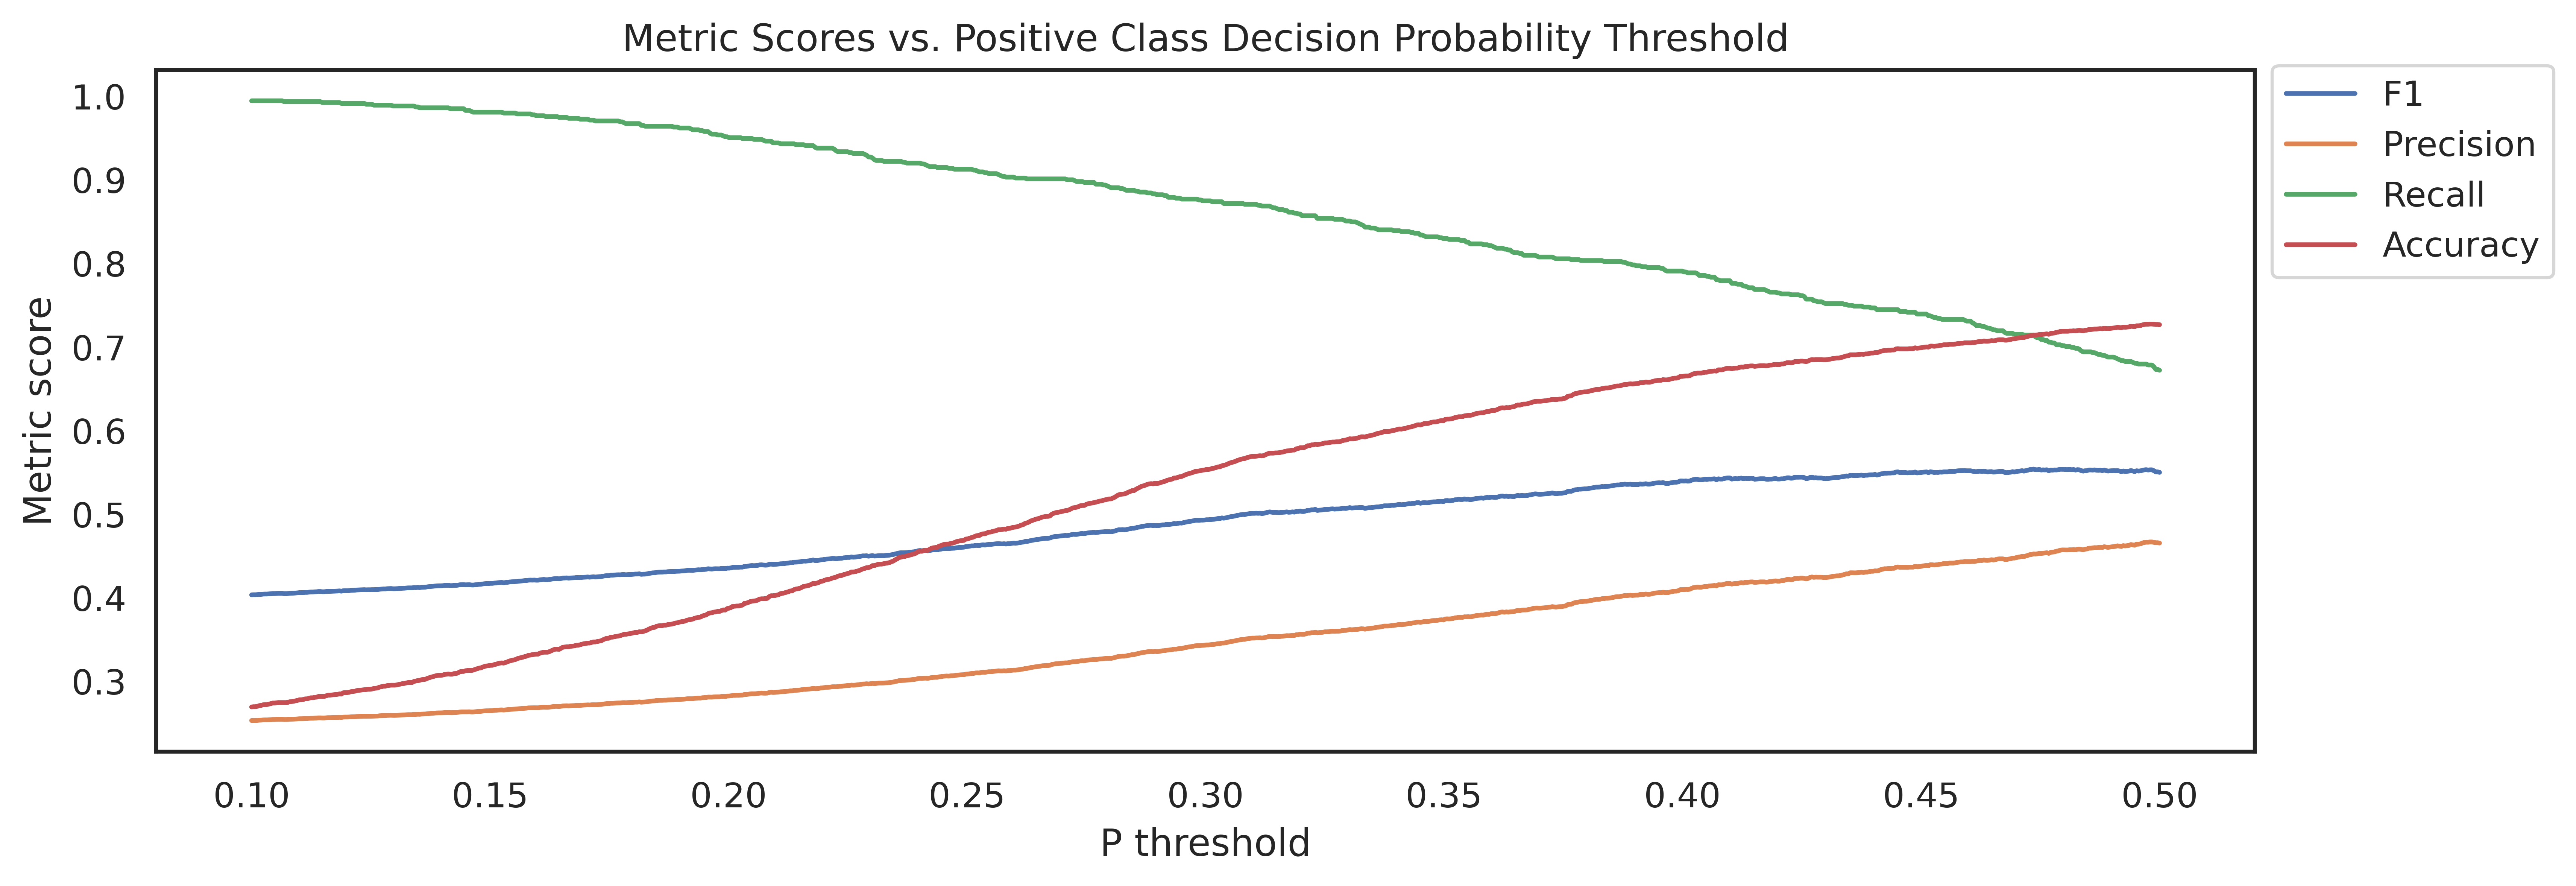

In [116]:
best_f1_score, best_thresh_p = show_curve(df)

In [42]:
print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' % (best_f1_score, best_thresh_p))

Logistic Regression Model best F1 score 0.565 at prob decision threshold >= 0.234


## Log Reg SMOTE

In [66]:
df = pd.read_csv('../data/aug_train.csv')

X = df.drop(['target'], axis = 1)
y = df['target']

In [67]:
num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

In [68]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

In [69]:
X = create_encoded_df(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

smote = SMOTE()
X_train_val, y_train_val = smote.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [71]:
results = pd.DataFrame(columns = ['LR', 'RF', 'XGB', 'LGBM', 'CB'], index = range(4))

In [72]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

In [73]:
# Metrics
results.iloc[0, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(roc_auc_score(y_test, y_prob), 3)
lg_cm = confusion_matrix(y_test, y_pred)

In [74]:
print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 50 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lg, X_train, y_train, cv = 50, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lg, X_train, y_train, cv = 50, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lg, X_train, y_train, cv = 50, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lg, X_train, y_train, cv = 50, scoring = 'f1').mean(), 2)}")

              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81      2880
         1.0       0.47      0.67      0.55       952

    accuracy                           0.73      3832
   macro avg       0.67      0.71      0.68      3832
weighted avg       0.77      0.73      0.74      3832

ROC AUC score: 0.765

-----------------------------------------------------

Cross-validation scores with 50 folds:

ROC AUC: 0.779
precision: 0.73
recall: 0.71
f1: 0.72


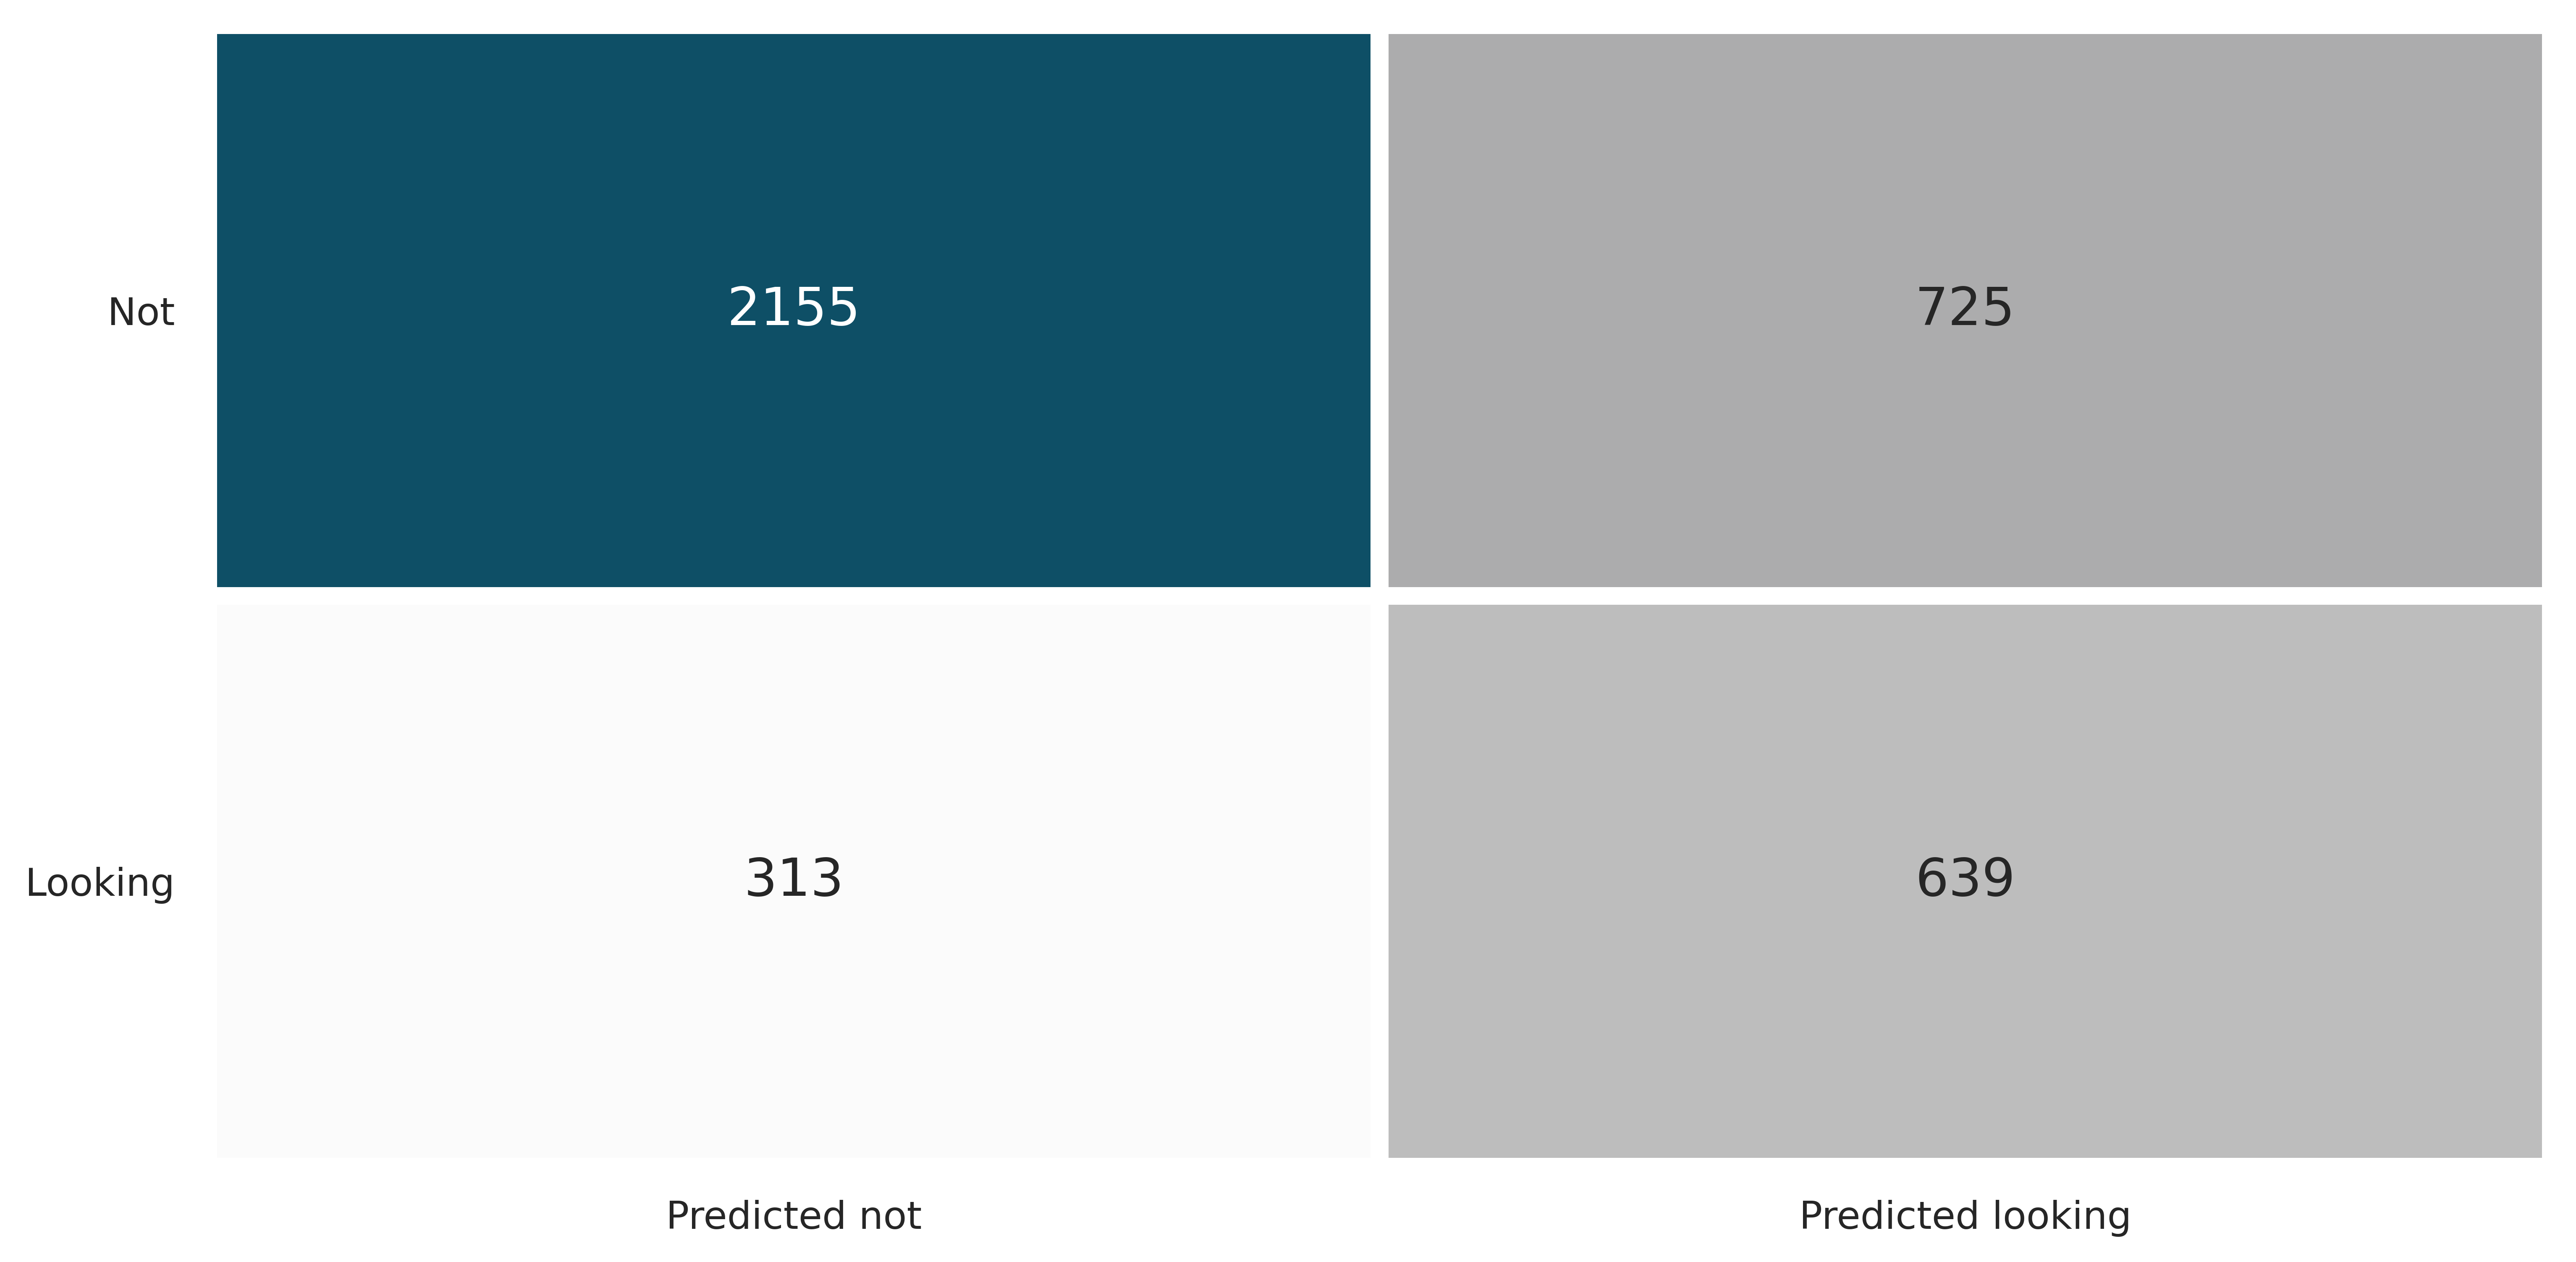

In [110]:
def conf_matrix():
    # Visualize confusion matrix
    plt.figure(figsize = (12, 6), dpi=300)
    colors = ["#fbfbfb", "#4b4b4c", "#0e4f66"]
    colormap = clrs.LinearSegmentedColormap.from_list("", colors)

    sns.heatmap(
        lg_cm,
        cmap = colormap,
        annot = True,
        fmt = 'd',
        linewidths = 5,
        cbar = False,
        annot_kws = {'fontsize': 15},
        yticklabels = ['Not', 'Looking'],
        xticklabels = ['Predicted not', 'Predicted looking']
    )

    plt.yticks(rotation = 0)

    plt.savefig('../img/matrix.png', format='png')

    return plt.show()

conf_matrix()

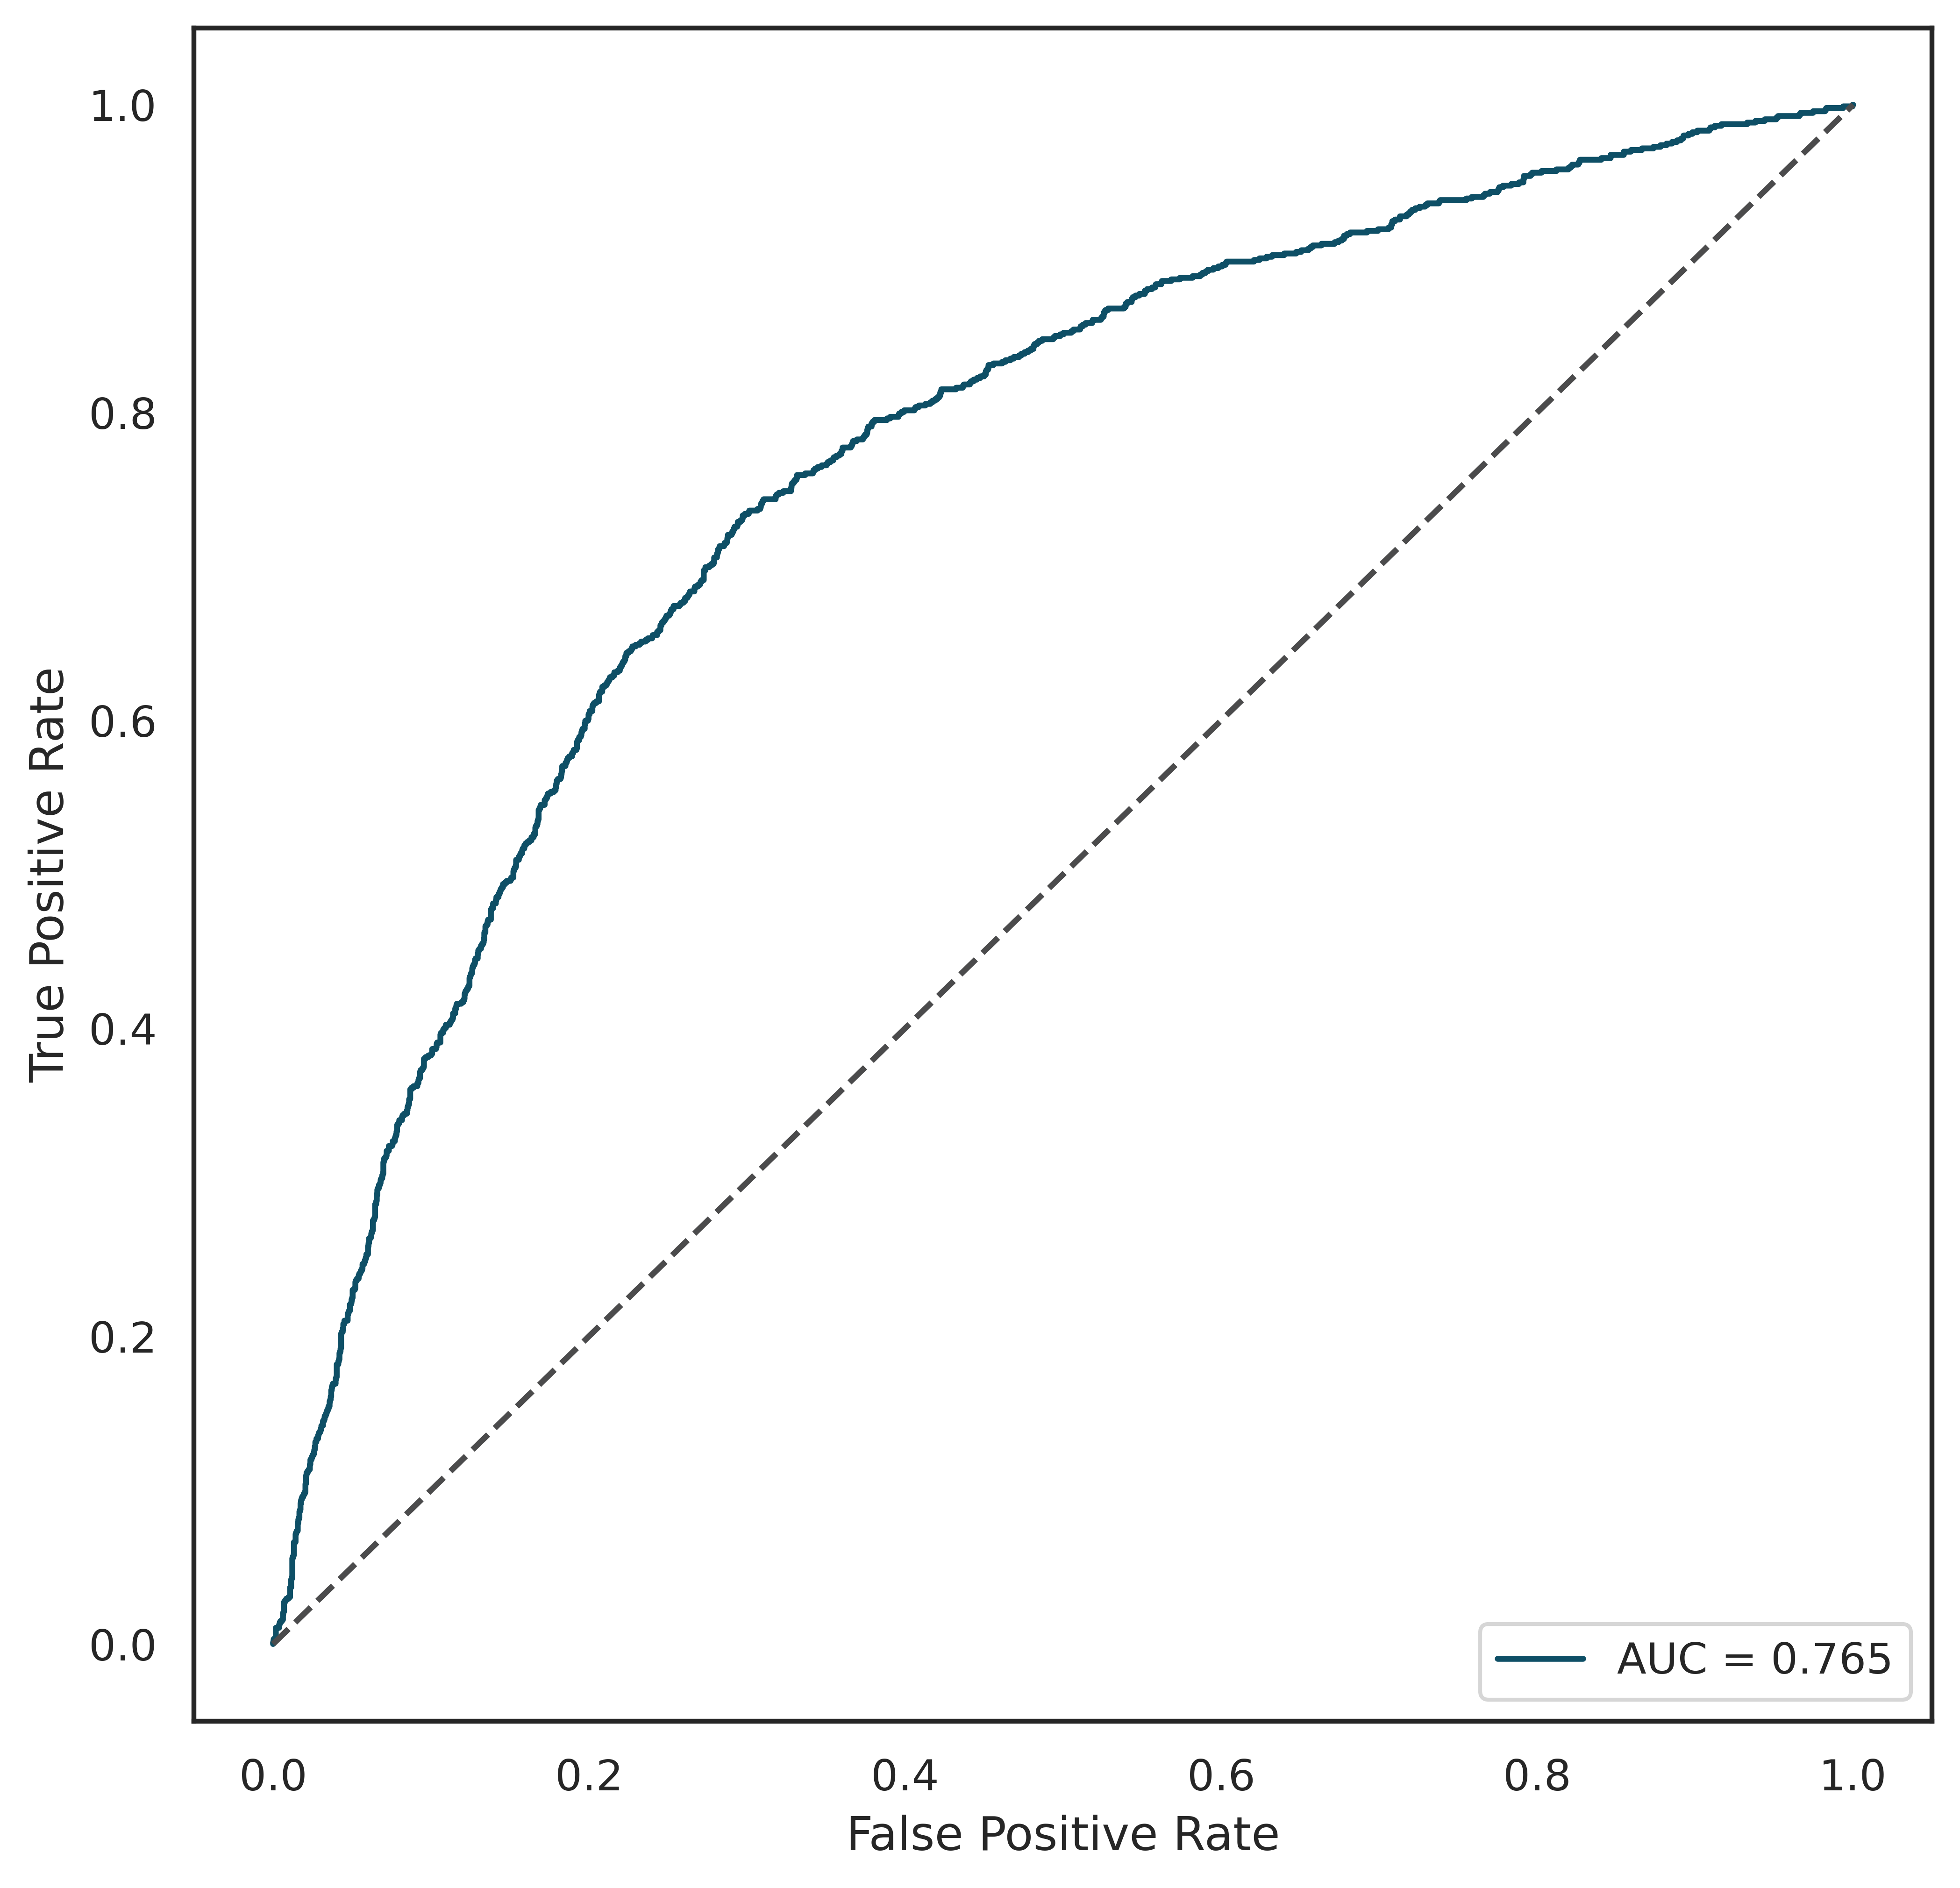

In [108]:
# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8), dpi=300)
plt.plot(false_positive_rate,true_positive_rate, color = "#0e4f66", label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = "#4b4b4c")
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('../img/auc.png', format='png')
plt.show()

In [99]:
colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)

# Feature importance
feature_importance = pd.DataFrame(columns = ['feature', 'importance (abs coef)'], index = range(13))

for i in range(len(feature_importance.index)):
    feature_importance.iloc[i, 0] = X_train.columns.to_list()[i]

feature_importance['importance (abs coef)'] = abs(lg.coef_)[0]

feature_importance = feature_importance.sort_values('importance (abs coef)', ascending = False)

feature_importance[0:12].style.background_gradient()

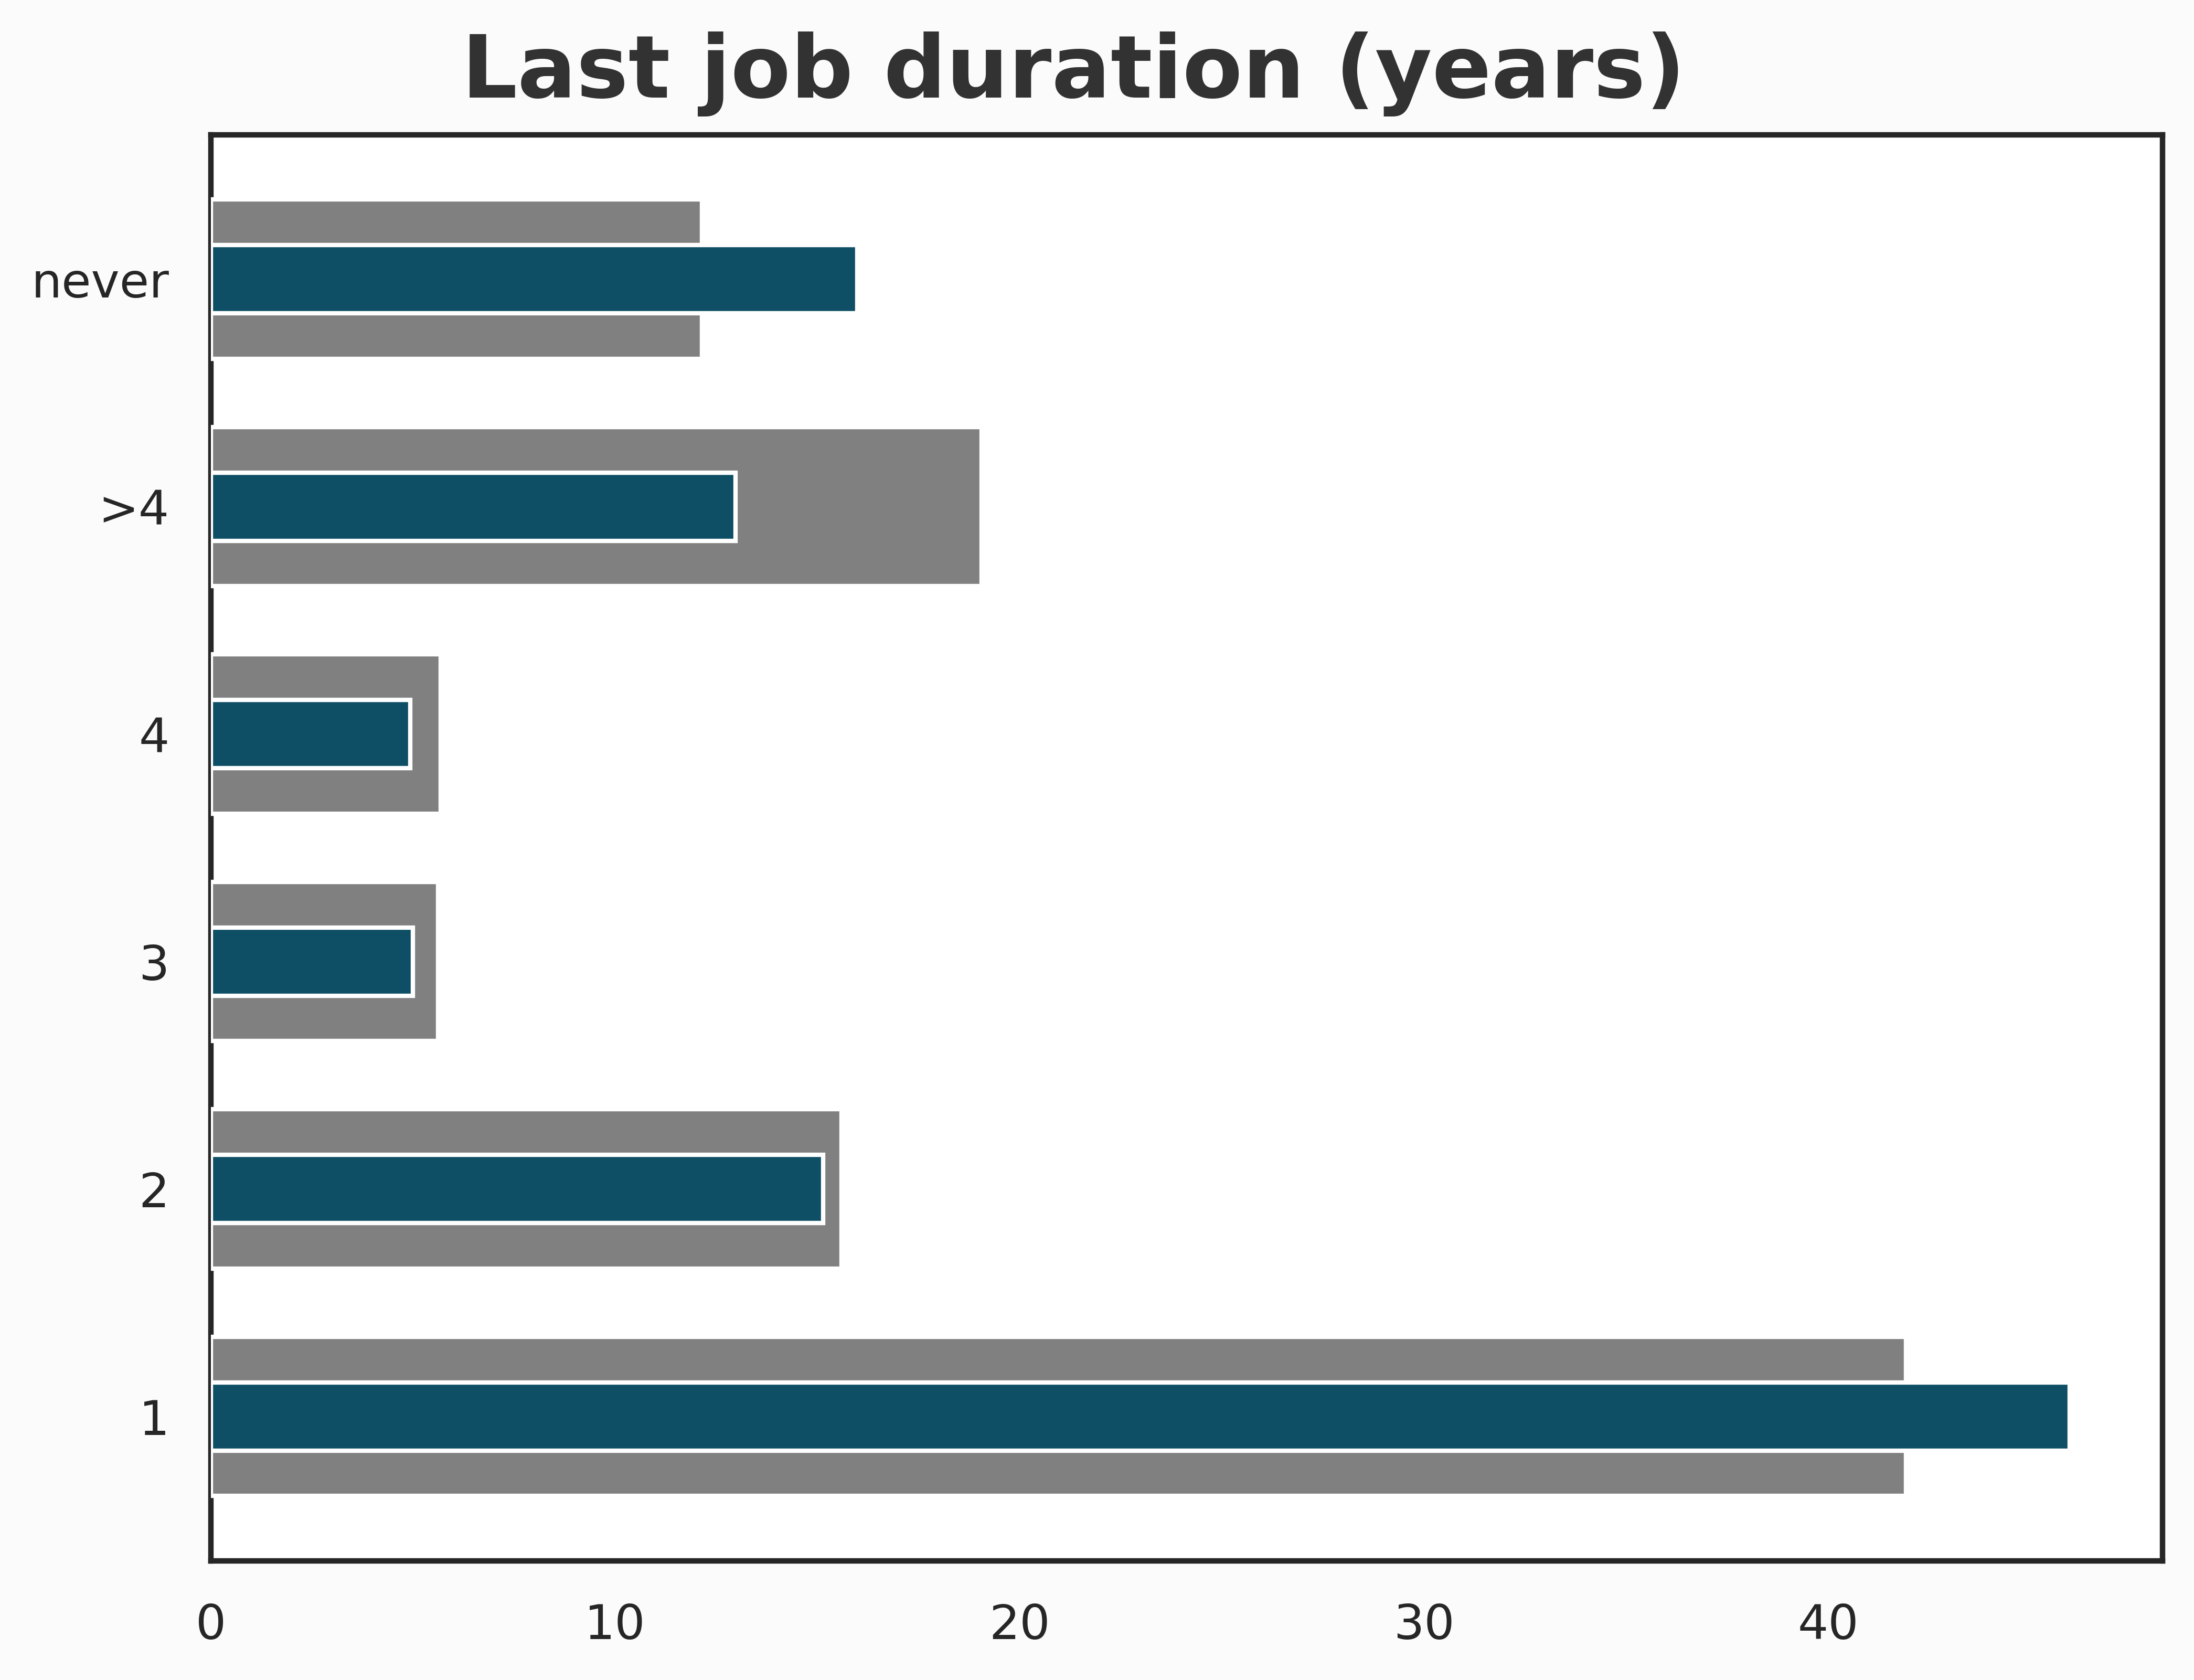

In [100]:
last_job_duration(df)

In [101]:
company_heatmap(df)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['Undisclosed'], dtype='object', name='gender'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
df.gender.value_counts